## Cross-National Inference — Cost Impact of Long COVID Services

**Author:** Ashkan Dashtban, PhD  
**Contact:** a.dashtban@ucl.ac.uk  
**Date:** Sept, 2025  
**Funding / Acknowledgement:** Implemented as part of the STIMULATE-ICP UK grant (~£6 million)

---

## Overview

This notebook implements a reproducible workflow to compare healthcare cost between **England** and **Wales**, exploring whether differences in observed cost changes are associated with the introduction of specialised Long-COVID services.  

Because national datasets cannot be linked at an individual level across countries, we rely on **Bayesian inference** and **Monte Carlo simulation** to:

1. Quantify cross-national differences in cost and utilisation rates  
2. Assess whether observed differences are consistent with:  
   - **H₀**: Baseline population differences  
   - **H₁**: The introduction of specialised services  


---

## Objectives

- Estimate and compare population-level cost distributions across England and Wales  
- Propagate uncertainty through Bayesian and MCMC methods  
- Model within-individual cost change using paired *pre→post* designs  

---


## Notebook Structure


### **Section 1 — Cross-national population inference (between-nation comparisons)**  
We apply a set of independent approaches to estimate population cost distributions and quantify uncertainty in cross-national contrasts:

1. **Hierarchical Bayesian Gamma model (partial pooling)**
   - Models group-level heterogeneity with Gamma likelihoods appropriate for right-skewed cost data.  

3. **Parametric marginal Monte Carlo simulation**  
   - Parametric bootstrapping of marginal distributions to estimate contrasts.  

4. **Robust Bayesian MCMC (Student-t on log scale, non-hierarchical)**  
   - Robust modelling of log-costs to downweight outliers.  

5. **Bayesian MCMC with Gamma likelihoods**  
   - Flexible MCMC inference using Gamma likelihoods and informative/weakly informative priors.  

6. **Delta-method (lognormal pseudo-draws)**  
   - Analytic delta method with pseudo-draws for validation and comparison.  

---

### **Section 2 — Paired (pre→post) analysis (within-individual comparisons)**  
We reconstruct and model within-individual cost changes using three complementary approaches:

1. **Bayesian paired log-means model**  
   - Multivariate normal approximation on log means for paired pre→post designs, providing posterior estimates of paired change.  

2. **Monte Carlo microdata reconstruction (Gaussian copula)**  
   - Simulate joint microdata consistent with observed marginals and correlations to estimate paired contrasts.  

3. **Paired Delta-method (analytic) + pseudo-draws for KDE**  
   - Analytic paired delta method with pseudo-draw generation for non-parametric density estimation.  


## Usage

1. Clone the repository  
2. Create a Python environment with the following packages:  

```text
pymc or pymc3
scipy
statsmodels
scikit-learn
numpy
pandas
matplotlib
seaborn
arviz

copulas
jupyterlab / notebook


# Section 1: Differential Cost Impact: exposed→unexposed

## 1. Hierarchical Bayesian Gamma Model with Partial Pooling

In [8]:
# Hierarchical Gamma aggregated-data model
import numpy as np, math
import pymc as pm, arviz as az
from scipy import stats

# --- Observed data from individual-level data ---
mean_lc_w, sd_lc_w, n_lc_w = 6681.6, 36188.3, 7923
mean_ctrl_w, sd_ctrl_w, n_ctrl_w = 2039.9, 9308.2, 30704
mean_lc_e, sd_lc_e, n_lc_e = 3378.3, 21015.2, 295180
mean_ctrl_e, sd_ctrl_e, n_ctrl_e = 1299.7, 6681.6, 1170300

group_keys = ["W_lc","W_ctrl","E_lc","E_ctrl"]
obs_means = np.array([mean_lc_w, mean_ctrl_w, mean_lc_e, mean_ctrl_e], dtype=float)
obs_sds   = np.array([sd_lc_w, sd_ctrl_w, sd_lc_e, sd_ctrl_e], dtype=float)
obs_ns    = np.array([n_lc_w, n_ctrl_w, n_lc_e, n_ctrl_e], dtype=int)

random_seed = 2025

def run_hierarchical_gamma_agg(draws=3000, tune=1500, chains=4, seed=random_seed, target_accept=0.95, return_model=False):
    """
    Hierarchical gamma aggregated-data model.
    Individual-level: X_ij ~ Gamma(shape=alpha_g, scale = theta_g)
      => mean mu_g = alpha_g * theta_g
      => var = mu_g^2 / alpha_g
    Aggregated likelihood:
      - obs_mean ~ Normal(mu_g, sqrt(var / n))
      - (n-1)*s2_obs / var ~ ChiSquare(n-1)  (added via pm.Potential using pm.logp())
    Hierarchical priors on log(mu_g) and log(alpha_g).
    Returns: idata, post_draws, post_summary
    """
    # small epsilon
    eps = 1e-12

    # sensible initial guesses for alpha per group from method-of-moments alpha = mean^2 / var
    alpha_guess_per_group = np.maximum(obs_means**2 / (obs_sds**2 + eps), 1e-3)
    global_alpha_guess = float(np.median(alpha_guess_per_group))

    with pm.Model() as model:
        # ----- Hyperpriors -----
        mu_log_pop = pm.Normal("mu_log_pop", mu=math.log(np.maximum(obs_means.mean(), 1e-6)), sigma=2.0)
        sigma_mu = pm.HalfNormal("sigma_mu", sigma=1.0)

        alpha_log_pop = pm.Normal("alpha_log_pop", mu=math.log(max(global_alpha_guess, 1e-3)), sigma=1.0)
        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1.0)

        # non-centered parameterization for per-group log(mu) and log(alpha)
        mu_raw = pm.Normal("mu_raw", mu=0.0, sigma=1.0, shape=4)
        mu_log_g = pm.Deterministic("mu_log_g", mu_log_pop + mu_raw * sigma_mu)
        mu_g = pm.Deterministic("mu_g", pm.math.exp(mu_log_g))   # means on original scale

        alpha_raw = pm.Normal("alpha_raw", mu=0.0, sigma=1.0, shape=4)
        alpha_log_g = pm.Deterministic("alpha_log_g", alpha_log_pop + alpha_raw * sigma_alpha)
        alpha_g = pm.Deterministic("alpha_g", pm.math.exp(alpha_log_g))

        # Theoretical variance on original scale: var_g = mu_g^2 / alpha_g
        var_g = pm.math.maximum(mu_g**2 / (alpha_g + eps), eps)

        # Aggregated-data likelihood for sample means (CLT approx)
        mean_sd = pm.math.sqrt(var_g / obs_ns)
        pm.Normal("obs_mean_like", mu=mu_g, sigma=mean_sd, observed=obs_means)

        # Aggregated-data likelihood for sample variances via chi-square relation
        for i, key in enumerate(group_keys):
            df = obs_ns[i] - 1
            s2_obs = float(obs_sds[i]**2)
            chisq_arg = (df * s2_obs) / (var_g[i] + eps)
            # Use pm.logp with ChiSquared.dist; add as Potential
            chi_dist = pm.ChiSquared.dist(nu=df)
            pm.Potential(f"obs_s2_chisq_like_{key}", pm.logp(chi_dist, chisq_arg))

        # Derived quantities
        mean_W_lc = pm.Deterministic("mean_W_lc", mu_g[0])
        mean_W_ctrl = pm.Deterministic("mean_W_ctrl", mu_g[1])
        mean_E_lc = pm.Deterministic("mean_E_lc", mu_g[2])
        mean_E_ctrl = pm.Deterministic("mean_E_ctrl", mu_g[3])

        fold_W = pm.Deterministic("fold_W", mean_W_lc / mean_W_ctrl)
        fold_E = pm.Deterministic("fold_E", mean_E_lc / mean_E_ctrl)
        ratio = pm.Deterministic("ratio", fold_W / fold_E)
        abs_DiD = pm.Deterministic("abs_DiD", (mean_W_lc - mean_W_ctrl) - (mean_E_lc - mean_E_ctrl))

        # Sample
        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed,
                          target_accept=target_accept, return_inferencedata=True)

    # flatten draws
    def flatten(name):
        return idata.posterior[name].values.reshape(-1)

    post_draws = {
        "fold_W": flatten("fold_W"),
        "fold_E": flatten("fold_E"),
        "ratio": flatten("ratio"),
        "abs_DiD": flatten("abs_DiD"),
        "mu_g": idata.posterior["mu_g"].values.reshape(-1, 4),
        "alpha_g": idata.posterior["alpha_g"].values.reshape(-1, 4)
    }

    post_summary = az.summary(idata, var_names=["fold_W","fold_E","ratio","abs_DiD","mu_g","alpha_g"])
    if return_model:
        return idata, post_draws, post_summary, model
    return idata, post_draws, post_summary


idata, post_draws, post_summary = run_hierarchical_gamma_agg(draws=3000, tune=1500, chains=4, seed=random_seed, target_accept=0.95, return_model=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_pop, sigma_mu, alpha_log_pop, sigma_alpha, mu_raw, alpha_raw]


Output()

Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 930 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [9]:
post_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fold_W,3.275,0.208,2.895,3.673,0.005,0.002,1826.0,3821.0,1.0
fold_E,2.601,0.032,2.542,2.661,0.000,0.000,14173.0,8247.0,1.0
ratio,1.259,0.081,1.102,1.408,0.002,0.001,1921.0,3857.0,1.0
abs_DiD,2533.855,392.804,1756.163,3248.632,9.450,4.855,1725.0,3766.0,1.0
mu_g[0],6645.384,388.368,5927.848,7395.735,9.358,4.818,1718.0,3663.0,1.0
mu_g[1],2030.498,52.074,1933.271,2128.227,0.542,0.530,9198.0,8048.0,1.0
mu_g[2],3380.611,38.306,3308.253,3450.064,0.320,0.378,14324.0,8542.0,1.0
mu_g[3],1299.580,6.175,1288.179,1311.338,0.057,0.062,11905.0,7852.0,1.0
alpha_g[0],0.034,0.004,0.027,0.042,0.000,0.000,1694.0,3702.0,1.0
alpha_g[1],0.048,0.002,0.043,0.052,0.000,0.000,9221.0,7428.0,1.0


In [10]:
idata.to_netcdf("hierarchical_gamma_idata.nc")
post_summary.to_csv("hierarchical_gamma_post_summary.csv")
np.savez("hierarchical_gamma_post_draws.npz", **post_draws)

'hierarchical_gamma_idata.nc'

In [ ]:
## Load hierarchical gamma model data
import arviz as az
import numpy as np
import pandas as pd
idata = az.from_netcdf("hierarchical_gamma_idata.nc")
ost_summary = pd.read_csv("hierarchical_gamma_post_summary.csv", index_col=0)
loaded = np.load("hierarchical_gamma_post_draws.npz")
post_draws = {k: loaded[k] for k in loaded.files}

## 2. **Parametric Marginal Monte Carlo Simulation** 
(lognormal/gamma microdata reconstruction)

In [20]:
import pandas as pd, numpy as np
import os
import scipy.stats as st
import math
from tqdm import trange  # progress bar (optional)
sns.set(style="whitegrid")
import matplotlib.pyplot as plt, seaborn as sns
import arviz as az
from scipy.stats import gamma as sp_gamma
from scipy.stats import lognorm as sp_lognorm
from scipy import stats
from tqdm import tqdm
sns.set(style="whitegrid")

random_seed = 2025
rng = np.random.default_rng(random_seed)


# Exposed (Long COVID) vs Contemporaneous Unexposed means (post window) per country
mean_lc_w, sd_lc_w, n_lc_w = 6681.6, 36188.3, 7923         # Wales exposed (Long COVID)
mean_ctrl_w, sd_ctrl_w, n_ctrl_w = 2039.9, 9308.2, 30704   # Wales contemporaneous unexposed

mean_lc_e, sd_lc_e, n_lc_e = 3378.3, 21015.2, 295180      # England exposed (Long COVID)
mean_ctrl_e, sd_ctrl_e, n_ctrl_e = 1299.7, 6681.6, 1170300 # England contemporaneous unexposed


# empirical rho and grid to test
rho_empirical = 0.15
rhos_to_run = [rho_empirical, 0.5, 0.8]

# Monte Carlo settings
n_mc = 50000             # Monte-Carlo iterations (increase for more precise MC CI)
marginals = ['lognormal', 'gamma']   # compare both
seed = 2025
max_indiv_sim = 2000   # threshold to simulate individuals for Wales; England uses CLT by default
output_dir = "did_mc_plots_outputs"
os.makedirs(output_dir, exist_ok=True)

# ---------------- Utilities ----------------
Z95 = abs(stats.norm.ppf(0.05/2))


def _var_of_mean(sd, n):
    return (sd**2) / n

def lognormal_params_from_mean_sd(mean, sd):
    var = sd**2
    sigma2 = math.log1p(var / (mean**2))
    sigma = math.sqrt(max(sigma2, 0.0))
    mu = math.log(max(mean, 1e-12)) - 0.5 * sigma2
    return mu, sigma

def gamma_params_from_mean_sd(mean, sd):
    var = sd**2
    mean = max(mean, 1e-12)
    var = max(var, 1e-12)
    alpha = mean**2 / var
    theta = var / mean
    return alpha, theta


def multiplicative_DiD_unpaired(mean_exp_w, sd_exp_w, n_exp_w,
                                mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                mean_exp_e, sd_exp_e, n_exp_e,
                                mean_ctrl_e, sd_ctrl_e, n_ctrl_e):
    # R_w = mean_exp_w / mean_ctrl_w, R_e = mean_exp_e / mean_ctrl_e
    Rw = mean_exp_w / mean_ctrl_w
    Re = mean_exp_e / mean_ctrl_e
    ratio = Rw / Re
    # Var(log(mean)) approx Var(mean)/mean^2
    varlog_mean_exp_w = _var_of_mean(sd_exp_w, n_exp_w) / (mean_exp_w**2)
    varlog_mean_ctrl_w = _var_of_mean(sd_ctrl_w, n_ctrl_w) / (mean_ctrl_w**2)
    varlog_Rw = varlog_mean_exp_w + varlog_mean_ctrl_w

    varlog_mean_exp_e = _var_of_mean(sd_exp_e, n_exp_e) / (mean_exp_e**2)
    varlog_mean_ctrl_e = _var_of_mean(sd_ctrl_e, n_ctrl_e) / (mean_ctrl_e**2)
    varlog_Re = varlog_mean_exp_e + varlog_mean_ctrl_e

    var_log_ratio = max(varlog_Rw + varlog_Re, 0.0)
    se_log = math.sqrt(var_log_ratio)
    ci_ratio = (math.exp(math.log(ratio)-Z95*se_log), math.exp(math.log(ratio)+Z95*se_log))
    z = math.log(ratio)/se_log if se_log>0 else np.nan
    pval = 2*(1-stats.norm.cdf(abs(z))) if se_log>0 else np.nan
    return {"ratio": ratio, "ci_low": ci_ratio[0], "ci_high": ci_ratio[1], "se_log": se_log, "z": z, "pval": pval}

def absolute_DiD_unpaired(mean_exp_w, sd_exp_w, n_exp_w,
                          mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                          mean_exp_e, sd_exp_e, n_exp_e,
                          mean_ctrl_e, sd_ctrl_e, n_ctrl_e):
    Dw = mean_exp_w - mean_ctrl_w
    De = mean_exp_e - mean_ctrl_e
    did = Dw - De
    var_Dw = _var_of_mean(sd_exp_w, n_exp_w) + _var_of_mean(sd_ctrl_w, n_ctrl_w)
    var_De = _var_of_mean(sd_exp_e, n_exp_e) + _var_of_mean(sd_ctrl_e, n_ctrl_e)
    var_did = var_Dw + var_De
    se = math.sqrt(max(var_did, 0.0))
    ci = (did - Z95*se, did + Z95*se)
    z = did/se if se>0 else np.nan
    pval = 2*(1-stats.norm.cdf(abs(z))) if se>0 else np.nan
    return {"DiD": did, "ci_low": ci[0], "ci_high": ci[1], "se": se, "z": z, "pval": pval}


# --- Monte-Carlo: simulate independent exposed and control samples (per country) ---
def montecarlo_did_unpaired(mean_exp_w, sd_exp_w, n_exp_w,
                            mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                            mean_exp_e, sd_exp_e, n_exp_e,
                            mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
                            rho_between=0.0, marginal='lognormal', n_mc=10000, seed=2025):
    """
    Simulate independent exposed vs control samples per country.
    rho_between kept for API parity but not used (groups independent).
    For large n (England) we simulate using CLT on sample means; for Wales we can simulate microdata if n small.
    """
    rng = np.random.default_rng(seed)

    # prepare params for marginals
    if marginal == 'lognormal':
        mu_exp_w, sigma_exp_w = lognormal_params_from_mean_sd(mean_exp_w, sd_exp_w)
        mu_ctrl_w, sigma_ctrl_w = lognormal_params_from_mean_sd(mean_ctrl_w, sd_ctrl_w)
        mu_exp_e, sigma_exp_e = lognormal_params_from_mean_sd(mean_exp_e, sd_exp_e)
        mu_ctrl_e, sigma_ctrl_e = lognormal_params_from_mean_sd(mean_ctrl_e, sd_ctrl_e)
    else:
        a_exp_w, th_exp_w = gamma_params_from_mean_sd(mean_exp_w, sd_exp_w)
        a_ctrl_w, th_ctrl_w = gamma_params_from_mean_sd(mean_ctrl_w, sd_ctrl_w)
        a_exp_e, th_exp_e = gamma_params_from_mean_sd(mean_exp_e, sd_exp_e)
        a_ctrl_e, th_ctrl_e = gamma_params_from_mean_sd(mean_ctrl_e, sd_ctrl_e)

    simulate_wales_micro = (n_exp_w + n_ctrl_w) <= max_indiv_sim

    ratio_draws = np.empty(n_mc)
    abs_draws = np.empty(n_mc)
    pct_draws = np.empty(n_mc)
    running_mean_ratio = np.empty(n_mc)

    fold_w_arr = np.empty(n_mc)
    fold_e_arr = np.empty(n_mc)
    abs_diff_e_arr = np.empty(n_mc)

    for it in tqdm(range(n_mc), desc=f"Simulating {marginal} DiD", unit="iter"):
        # Wales
        if simulate_wales_micro:
            # simulate exposed and control independently
            if marginal=='lognormal':
                exp_w = np.exp(mu_exp_w + sigma_exp_w * rng.standard_normal(n_exp_w))
                ctrl_w = np.exp(mu_ctrl_w + sigma_ctrl_w * rng.standard_normal(n_ctrl_w))
            else:
                u1 = rng.random(n_exp_w); u2 = rng.random(n_ctrl_w)
                exp_w = stats.gamma.ppf(u1, a=a_exp_w, scale=th_exp_w)
                ctrl_w = stats.gamma.ppf(u2, a=a_ctrl_w, scale=th_ctrl_w)
            mean_exp_w_sim = exp_w.mean()
            mean_ctrl_w_sim = ctrl_w.mean()
        else:
            # CLT for sample means (bivariate is not needed; independent)
            mean_exp_w_sim = rng.normal(loc=mean_exp_w, scale=sd_exp_w/math.sqrt(n_exp_w))
            mean_ctrl_w_sim = rng.normal(loc=mean_ctrl_w, scale=sd_ctrl_w/math.sqrt(n_ctrl_w))

        # England (large N): CLT on sample means
        mean_exp_e_sim = rng.normal(loc=mean_exp_e, scale=sd_exp_e/math.sqrt(n_exp_e))
        mean_ctrl_e_sim = rng.normal(loc=mean_ctrl_e, scale=sd_ctrl_e/math.sqrt(n_ctrl_e))

        # estimands
        fold_w = mean_exp_w_sim / mean_ctrl_w_sim if mean_ctrl_w_sim>0 else np.nan
        fold_e = mean_exp_e_sim / mean_ctrl_e_sim if mean_ctrl_e_sim>0 else np.nan
        ratio_draws[it] = fold_w / fold_e
        abs_draws[it] = (mean_exp_w_sim - mean_ctrl_w_sim) - (mean_exp_e_sim - mean_ctrl_e_sim)
        pct_draws[it] = (fold_w - 1.0) - (fold_e - 1.0)
        running_mean_ratio[it] = ratio_draws[:it+1].mean()

        fold_w_arr[it] = fold_w
        fold_e_arr[it] = fold_e
        abs_diff_e_arr[it] = mean_exp_e_sim - mean_ctrl_e_sim
        

    # assemble summaries (same summarizer you used)
    def summarize(x):
        mean = np.nanmean(x); sd = np.nanstd(x, ddof=1)
        lo, hi = np.nanpercentile(x, [2.5, 97.5])
        se = sd
        z = mean/se if se>0 else np.nan
        pval = 2*(1-stats.norm.cdf(abs(z))) if se>0 else np.nan
        return {"mean":mean, "sd":sd, "ci_low":lo, "ci_high":hi, "se":se, "z":z, "pval":pval}

    sum_ratio = summarize(ratio_draws)
    sum_abs = summarize(abs_draws)
    sum_pct = summarize(pct_draws)

    draws = {
    "ratio": ratio_draws,
    "abs": abs_draws,
    "pct": pct_draws,
    "fold_w": fold_w_arr,
    "fold_e": fold_e_arr,
    "abs_diff_e": abs_diff_e_arr,
    "running_mean_ratio": running_mean_ratio
    }

    #draws = {"ratio": ratio_draws, "abs": abs_draws, "pct": pct_draws, "running_mean_ratio": running_mean_ratio}
    summary_df = pd.DataFrame([
        {"rho":rho_between, "estimand":"multiplicative_ratio", **sum_ratio},
        {"rho":rho_between, "estimand":"absolute_DiD", **sum_abs},
        {"rho":rho_between, "estimand":"percent_change_DiD", **sum_pct}
    ])
    return draws, summary_df



draws, summary = montecarlo_did_unpaired(mean_lc_w, sd_lc_w, n_lc_w,
                                             mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                             mean_lc_e, sd_lc_e, n_lc_e,
                                             mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
                                             marginal="lognormal", n_mc=n_mc, seed=seed)
display(summary)

draws, summary = montecarlo_did_unpaired(mean_lc_w, sd_lc_w, n_lc_w,
                                             mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                             mean_lc_e, sd_lc_e, n_lc_e,
                                             mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
                                             marginal="gamma", n_mc=n_mc, seed=seed)
display(summary)


Simulating lognormal DiD: 100%|█| 50000/50000 [00:01<00:00, 31107.39iter


,rho,estimand,mean,sd,ci_low,ci_high,se,z,pval
0,0.0,multiplicative_ratio,1.261042,0.085098,1.095849,1.429723,0.085098,14.818642,0.000000e+00
1,0.0,absolute_DiD,2562.416880,412.721912,1748.948308,3366.399591,412.721912,6.208580,5.346561e-10
2,0.0,percent_change_DiD,0.678044,0.219800,0.249229,1.112953,0.219800,3.084819,2.036758e-03


Simulating gamma DiD: 100%|██| 50000/50000 [00:01<00:00, 36511.76iter/s]


,rho,estimand,mean,sd,ci_low,ci_high,se,z,pval
0,0.0,multiplicative_ratio,1.261042,0.085098,1.095849,1.429723,0.085098,14.818642,0.000000e+00
1,0.0,absolute_DiD,2562.416880,412.721912,1748.948308,3366.399591,412.721912,6.208580,5.346561e-10
2,0.0,percent_change_DiD,0.678044,0.219800,0.249229,1.112953,0.219800,3.084819,2.036758e-03


## 3. Robust Bayesian MCMC: Student-t on log scale (non-hierarchical) 

In [22]:
# Robust Bayesian MCMC: Student-t on log scale (non-hierarchical)
import numpy as np, math
import pymc as pm, arviz as az
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

sns.set(style="whitegrid")
random_seed = 2025

# -------------------------------
# INPUTS: aggregated summaries per group
# order: [W_lc, W_ctrl, E_lc, E_ctrl]
mean_lc_w, sd_lc_w, n_lc_w = 6681.6, 36188.3, 7923         # Wales exposed
mean_ctrl_w, sd_ctrl_w, n_ctrl_w = 2039.9, 9308.2, 30704   # Wales control
mean_lc_e, sd_lc_e, n_lc_e = 3378.3, 21015.2, 295180      # England exposed
mean_ctrl_e, sd_ctrl_e, n_ctrl_e = 1299.7, 6681.6, 1170300 # England control

group_keys = ["W_lc", "W_ctrl", "E_lc", "E_ctrl"]
obs_means = np.array([mean_lc_w, mean_ctrl_w, mean_lc_e, mean_ctrl_e], dtype=float)
obs_sds   = np.array([sd_lc_w, sd_ctrl_w, sd_lc_e, sd_ctrl_e], dtype=float)
obs_ns    = np.array([n_lc_w, n_ctrl_w, n_lc_e, n_ctrl_e], dtype=int)

# Small helpers (delta approximations on log scale)
def approx_log_mean_and_se(mean, sd, n):
    mean = max(mean, 1e-12)
    log_mean = math.log(mean)
    # se(log(mean)) ≈ (sd / sqrt(n)) / mean
    se_log_mean = (sd / math.sqrt(n)) / mean
    return log_mean, max(se_log_mean, 1e-12)

obs_logmean = np.zeros(4)
obs_logmean_se = np.zeros(4)
for i in range(4):
    obs_logmean[i], obs_logmean_se[i] = approx_log_mean_and_se(obs_means[i], obs_sds[i], obs_ns[i])

# -------------------------------
# Model function
def run_robust_studentt_log_model(draws=2000, tune=1000, chains=4, seed=random_seed, target_accept=0.9, return_model=False):
    """
    Non-hierarchical Student-t on log(cost) model using aggregated inputs.
    Returns: idata, post_draws_dict, post_summary_df
    post_draws_dict contains flattened posterior draws for:
      - fold_W, fold_E, ratio, abs_DiD_median, median_g, mu_log_g, sigma_log_g, nu
    Also provides posterior predictive aggregated draws function.
    """
    with pm.Model() as model:
        # Group-level location (mu_log_g) - independent, weak prior
        mu_log_g = pm.Normal("mu_log_g", mu=np.log(np.maximum(obs_means, 1.0)), sigma=5.0, shape=4)

        # Group-level scale on log-scale (sigma_log_g) - positive
        sigma_log_g = pm.HalfNormal("sigma_log_g", sigma=1.0, shape=4)

        # Degrees of freedom for Student-t (nu > 2 preferred)
        nu_minus2 = pm.Exponential("nu_minus2", lam=1/2.0)   # mean 2
        nu = pm.Deterministic("nu", nu_minus2 + 2.0)

        # Observed aggregated log-means: model using StudentT with observational SE (robust)
        # Use the CLT se for the observed log-mean as the observation noise
        for i, key in enumerate(group_keys):
            se_i = float(obs_logmean_se[i])
            # StudentT observational likelihood (robust to outliers in the sample mean)
            pm.StudentT(f"obs_logmean_{key}", nu=nu, mu=mu_log_g[i], sigma=se_i, observed=float(obs_logmean[i]))

        # Deterministic derived quantities on original scale (medians/geometric means)
        median_g = pm.Deterministic("median_g", pm.math.exp(mu_log_g))
        fold_W = pm.Deterministic("fold_W", pm.math.exp(mu_log_g[0] - mu_log_g[1]))
        fold_E = pm.Deterministic("fold_E", pm.math.exp(mu_log_g[2] - mu_log_g[3]))
        ratio = pm.Deterministic("ratio", fold_W / fold_E)
        abs_DiD_median = pm.Deterministic("abs_DiD_median",
                                          (pm.math.exp(mu_log_g[0]) - pm.math.exp(mu_log_g[1]))
                                          - (pm.math.exp(mu_log_g[2]) - pm.math.exp(mu_log_g[3])))

        # Sample
        idata = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=seed,
                          target_accept=target_accept, return_inferencedata=True)

    # flatten draws utility
    def flatten1d(name):
        return idata.posterior[name].values.reshape(-1)
    def flatten2d(name):
        arr = idata.posterior[name].values
        # (chains, draws, dim) -> (-1, dim)
        return arr.reshape(-1, arr.shape[-1])

    post_draws = {
        "fold_W": flatten1d("fold_W"),
        "fold_E": flatten1d("fold_E"),
        "ratio": flatten1d("ratio"),
        "abs_DiD_median": flatten1d("abs_DiD_median"),
        "median_g": flatten2d("median_g"),
        "mu_log_g": flatten2d("mu_log_g"),
        "sigma_log_g": flatten2d("sigma_log_g"),
        "nu": flatten1d("nu")
    }

    post_summary = az.summary(idata, var_names=["fold_W","fold_E","ratio","abs_DiD_median","median_g","mu_log_g","sigma_log_g","nu"])
    if return_model:
        return idata, post_draws, post_summary, model
    return idata, post_draws, post_summary

# -------------------------------
# Posterior simulation utilities for CCDF and PPC

def simulate_individuals_from_posterior(idata, n_draws=500, n_per_draw=1000, seed=2026):
    """
    Simulate individual-level costs (original scale) from posterior draws.
    - idata: inference data returned by run_robust_studentt_log_model
    - n_draws: number of posterior draws to sample
    - n_per_draw: number of individuals to simulate per group per draw
    Returns dict with arrays for each group (concatenated across draws).
    Warning: memory can grow quickly.
    """
    rng = np.random.default_rng(seed)
    mu_arr = idata.posterior["mu_log_g"].values.reshape(-1, 4)
    sigma_arr = idata.posterior["sigma_log_g"].values.reshape(-1, 4)
    nu_arr = idata.posterior["nu"].values.reshape(-1)
    nsamps = mu_arr.shape[0]
    pick = rng.choice(np.arange(nsamps), size=min(n_draws, nsamps), replace=False)

    sim = {g: [] for g in group_keys}
    for idx in pick:
        mu_vec = mu_arr[idx]
        sigma_vec = sigma_arr[idx]
        nu_val = float(nu_arr[idx])
        for gi, g in enumerate(group_keys):
            # draw Student-t on log scale then exponentiate
            y = rng.standard_t(df=nu_val, size=n_per_draw) * float(sigma_vec[gi]) + float(mu_vec[gi])
            sim[g].append(np.exp(y))
    for g in group_keys:
        sim[g] = np.concatenate(sim[g])
    return sim

def posterior_predictive_aggregates(idata, n_draws=1000, seed=2027):
    """
    For each selected posterior draw, simulate n_i individuals per group (matching obs_ns)
    and compute aggregated sample means (and resulting ratio/folds). Returns arrays:
      - mean_boot[group] arrays (n_draws)
      - ratio_boot, fold_W_boot, fold_E_boot, abs_DiD_boot (based on sample means)
    This is a PPC at the aggregated level.
    """
    rng = np.random.default_rng(seed)
    mu_arr = idata.posterior["mu_log_g"].values.reshape(-1, 4)
    sigma_arr = idata.posterior["sigma_log_g"].values.reshape(-1, 4)
    nu_arr = idata.posterior["nu"].values.reshape(-1)
    nsamps = mu_arr.shape[0]
    pick = rng.choice(np.arange(nsamps), size=min(n_draws, nsamps), replace=False)

    mean_boot = {g: np.empty(len(pick)) for g in group_keys}
    fold_W_boot = np.empty(len(pick))
    fold_E_boot = np.empty(len(pick))
    ratio_boot = np.empty(len(pick))
    abs_DiD_boot = np.empty(len(pick))

    for ii, idx in enumerate(pick):
        mu_vec = mu_arr[idx]
        sigma_vec = sigma_arr[idx]
        nu_val = float(nu_arr[idx])

        # simulate group sample values (size = obs_ns[group])
        sim_means = []
        for gi, g in enumerate(group_keys):
            n_i = int(obs_ns[gi])
            # simulate n_i individual draws
            # (use smaller internal sample if n_i large: Monte Carlo approximation)
            # To avoid simulating millions when n_i huge, simulate up to 20000 and use CLT for bigger sizes
            if n_i <= 20000:
                y = rng.standard_t(df=nu_val, size=n_i) * float(sigma_vec[gi]) + float(mu_vec[gi])
                vals = np.exp(y)
                mean_boot[g][ii] = vals.mean()
                sim_means.append(vals.mean())
            else:
                # CLT approx: mean of exp(Y) approximated by simulate many small draws
                m = 20000
                y = rng.standard_t(df=nu_val, size=m) * float(sigma_vec[gi]) + float(mu_vec[gi])
                vals = np.exp(y)
                mean_boot[g][ii] = vals.mean()  # Monte Carlo approx to population mean
                sim_means.append(vals.mean())

        # compute folds/ratio/abs using these sample means
        me_W_lc = mean_boot["W_lc"][ii]; mc_W = mean_boot["W_ctrl"][ii]
        me_E_lc = mean_boot["E_lc"][ii]; mc_E = mean_boot["E_ctrl"][ii]
        # guard
        mc_W = max(mc_W, 1e-12); mc_E = max(mc_E, 1e-12)
        fold_W_boot[ii] = me_W_lc / mc_W
        fold_E_boot[ii] = me_E_lc / mc_E
        ratio_boot[ii] = fold_W_boot[ii] / fold_E_boot[ii] if fold_E_boot[ii] != 0 else np.nan
        abs_DiD_boot[ii] = (me_W_lc - mc_W) - (me_E_lc - mc_E)

    return {
        "mean_boot": mean_boot,
        "fold_W_boot": fold_W_boot,
        "fold_E_boot": fold_E_boot,
        "ratio_boot": ratio_boot,
        "abs_DiD_boot": abs_DiD_boot
    }


In [23]:

# -------------------------------
# Example usage
# Run MCMC (adjust draws/tune/chains)
idata_r, post_draws_r, post_summary_r = run_robust_studentt_log_model(draws=2000, tune=1000, chains=4, seed=random_seed)
print(post_summary_r)

# Flattened draws for KDE plotting (examples)
ratio_draws = post_draws_r["ratio"]
fold_W_draws = post_draws_r["fold_W"]
fold_E_draws = post_draws_r["fold_E"]
abs_median_draws = post_draws_r["abs_DiD_median"]
median_g_draws = post_draws_r["median_g"]   # shape (n_samples, 4) array

# CCDF sim: simulate individuals from posterior (for CCDF plotting — original cost scale)
sim_indivs = simulate_individuals_from_posterior(idata_r, n_draws=500, n_per_draw=200, seed=2028)
# sim_indivs is dict: arrays for each group (big arrays you can feed to log-log CCDF)

# PPC aggregated: simulate aggregated sample means & DiD estimands
ppc_agg = posterior_predictive_aggregates(idata_r, n_draws=500, seed=2029)
# ppc_agg includes ratio_boot, fold_W_boot, fold_E_boot, abs_DiD_boot arrays suitable for KDEs

# Put posterior summary into a tidy DataFrame for quick copy/paste
summary_df = post_summary_r.reset_index().rename(columns={"index":"variable"})
display(summary_df)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_g, sigma_log_g, nu_minus2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


                    mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
fold_W             3.291    0.443     2.660     3.922      0.011    0.080   
fold_E             2.600    0.053     2.505     2.691      0.001    0.002   
ratio              1.266    0.172     1.023     1.515      0.004    0.030   
abs_DiD_median  2590.566  872.619  1338.620  3760.497     22.030  171.656   
median_g[0]     6712.985  869.433  5401.179  7776.117     22.210  172.795   
median_g[1]     2043.364   96.168  1899.577  2190.713      2.538   15.163   
median_g[2]     3378.734   63.544  3263.238  3485.295      1.028    3.369   
median_g[3]     1299.679    9.992  1282.280  1316.209      0.156    0.593   
mu_log_g[0]        8.805    0.121     8.623     8.983      0.003    0.020   
mu_log_g[1]        7.621    0.044     7.549     7.692      0.001    0.005   
mu_log_g[2]        8.125    0.019     8.091     8.157      0.000    0.001   
mu_log_g[3]        7.170    0.008     7.156     7.183      0.000    0.000   

/var/folders/cz/kywq1ms94x5dnx9g182h2_xc0000gn/T/ipykernel_52545/1506665656.py:175: RuntimeWarning: overflow encountered in exp
  vals = np.exp(y)


,variable,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,fold_W,3.291,0.443,2.660,3.922,0.011,0.080,4779.0,2515.0,1.0
1,fold_E,2.600,0.053,2.505,2.691,0.001,0.002,5275.0,2753.0,1.0
2,ratio,1.266,0.172,1.023,1.515,0.004,0.030,4674.0,2505.0,1.0
3,abs_DiD_median,2590.566,872.619,1338.620,3760.497,22.030,171.656,5211.0,2911.0,1.0
4,median_g[0],6712.985,869.433,5401.179,7776.117,22.210,172.795,5220.0,2742.0,1.0
5,median_g[1],2043.364,96.168,1899.577,2190.713,2.538,15.163,6751.0,3257.0,1.0
6,median_g[2],3378.734,63.544,3263.238,3485.295,1.028,3.369,5513.0,3061.0,1.0
7,median_g[3],1299.679,9.992,1282.280,1316.209,0.156,0.593,6703.0,2924.0,1.0
8,mu_log_g[0],8.805,0.121,8.623,8.983,0.003,0.020,5220.0,2742.0,1.0
9,mu_log_g[1],7.621,0.044,7.549,7.692,0.001,0.005,6751.0,3257.0,1.0


## 4. Bayesian MCMC model with Gamma likelihoods

This models individual costs as Gamma(α_g, θ_g) and uses the fact that the sample mean of n i.i.d. Gamma(α, θ) has Gamma(shape = n*α, scale = θ/n). Implementation uses parameterization with alpha and beta (rate). We put weak priors on per-group α and μ (mean).

1- specify a fully probabilistic model with priors on group-level latent parameters (shape alpha_g and mean mu_g of Gamma).

2- model the observed sample means as Gamma distributed with parameters informed by group-level parameters and sample sizes.

3- fit this hierarchical model by sampling from the joint posterior via Markov Chain Monte Carlo (MCMC) (PyMC pm.sample).

4- derive posterior distributions of estimands (fold changes, ratios, DiD differences).


In [132]:
import pymc as pm, arviz as az
import numpy as np
import math
import matplotlib.pyplot as plt, seaborn as sns
sns.set()

# Priors
draws = 20000; tune = 5000; chains=4
# Weak priors
mu_prior_scale = 1e4
alpha_prior = 1.0   # reasonably vague on shape

with pm.Model() as model_gamma:
    # group-level latent per-individual parameters: alpha_g (shape) and mu_g (mean)
    alpha_W_lc  = pm.HalfNormal("alpha_W_lc", sigma=alpha_prior)
    alpha_W_ctrl= pm.HalfNormal("alpha_W_ctrl", sigma=alpha_prior)
    alpha_E_lc  = pm.HalfNormal("alpha_E_lc", sigma=alpha_prior)
    alpha_E_ctrl= pm.HalfNormal("alpha_E_ctrl", sigma=alpha_prior)

    mu_W_lc  = pm.HalfNormal("mu_W_lc", sigma=mu_prior_scale)
    mu_W_ctrl= pm.HalfNormal("mu_W_ctrl", sigma=mu_prior_scale)
    mu_E_lc  = pm.HalfNormal("mu_E_lc", sigma=mu_prior_scale)
    mu_E_ctrl= pm.HalfNormal("mu_E_ctrl", sigma=mu_prior_scale)

    # For a Gamma with shape alpha and mean mu, theta = mu/alpha (scale)
    # Observed sample mean ~ Gamma(shape = n*alpha, scale = theta/n)
    def gamma_mean_obs(name, alpha_g, mu_g, n, obs_mean):
        # shape_obs = n * alpha_g
        # scale_obs = (mu_g / alpha_g) / n = mu_g / (alpha_g * n)
        shape_obs = n * alpha_g
        scale_obs = mu_g / (alpha_g * n + 1e-12)
        # PyMC Gamma uses alpha (shape) and beta (rate): mean = alpha / beta
        # convert scale->rate: beta_obs = 1/scale_obs
        beta_obs = 1.0 / scale_obs
        pm.Gamma(name, alpha=shape_obs, beta=beta_obs, observed=obs_mean)

    gamma_mean_obs("obs_W_lc", alpha_W_lc, mu_W_lc, n_lc_w, mean_lc_w)
    gamma_mean_obs("obs_W_ctrl", alpha_W_ctrl, mu_W_ctrl, n_ctrl_w, mean_ctrl_w)
    gamma_mean_obs("obs_E_lc", alpha_E_lc, mu_E_lc, n_lc_e, mean_lc_e)
    gamma_mean_obs("obs_E_ctrl", alpha_E_ctrl, mu_E_ctrl, n_ctrl_e, mean_ctrl_e)

    # Derived estimands
    fold_W = pm.Deterministic("fold_W", mu_W_lc / mu_W_ctrl)
    fold_E = pm.Deterministic("fold_E", mu_E_lc / mu_E_ctrl)
    ratio  = pm.Deterministic("ratio", fold_W / fold_E)
    abs_DiD= pm.Deterministic("abs_DiD", (mu_W_lc - mu_W_ctrl) - (mu_E_lc - mu_E_ctrl))

    idata_gamma = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=random_seed, target_accept=0.95, return_inferencedata=True)

# Extract draws
ratio_g = idata_gamma.posterior["ratio"].values.flatten()
abs_g = idata_gamma.posterior["abs_DiD"].values.flatten()
print(az.summary(idata_gamma, var_names=["fold_W","fold_E","ratio","abs_DiD"]))

# For CCDF: simulate individual-level draws using posterior mean of mu,alpha for each group
post_df = az.summary(idata_gamma, var_names=["mu_W_lc","mu_W_ctrl","mu_E_lc","mu_E_ctrl","alpha_W_lc","alpha_W_ctrl","alpha_E_lc","alpha_E_ctrl"])
# pick posterior medians
meds = post_df["mean"].to_dict()
def simulate_gamma_from_post(median_mu, median_alpha, n_indiv=20000):
    theta = median_mu/median_alpha
    return np.random.default_rng(random_seed).gamma(shape=median_alpha, scale=theta, size=n_indiv)

sim_W_lc_g = simulate_gamma_from_post(meds["mu_W_lc"], meds["alpha_W_lc"], n_indiv=20000)
sim_E_lc_g = simulate_gamma_from_post(meds["mu_E_lc"], meds["alpha_E_lc"], n_indiv=20000)
sim_W_ctrl_g = simulate_gamma_from_post(meds["mu_W_ctrl"], meds["alpha_W_ctrl"], n_indiv=20000)
sim_E_ctrl_g = simulate_gamma_from_post(meds["mu_E_ctrl"], meds["alpha_E_ctrl"], n_indiv=20000)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_W_lc, alpha_W_ctrl, alpha_E_lc, alpha_E_ctrl, mu_W_lc, mu_W_ctrl, mu_E_lc, mu_E_ctrl]


Output()

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 165 seconds.


             mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
fold_W      3.277    0.092     3.119     3.426      0.001    0.004   16174.0   
fold_E      2.599    0.012     2.580     2.620      0.000    0.000   16168.0   
ratio       1.261    0.036     1.201     1.322      0.000    0.001   15744.0   
abs_DiD  2566.333  162.261  2298.284  2843.928      1.639    4.962   18374.0   

         ess_tail  r_hat  
fold_W    12939.0    1.0  
fold_E    12161.0    1.0  
ratio     13179.0    1.0  
abs_DiD   15932.0    1.0  


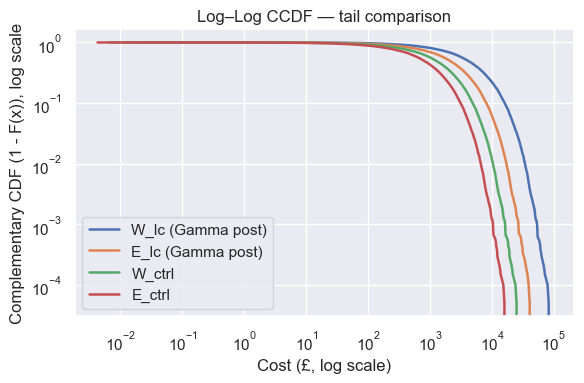

In [134]:
ccdf_loglog_plot([sim_W_lc_g, sim_E_lc_g, sim_W_ctrl_g, sim_E_ctrl_g],
                 labels=["W_lc (Gamma post)", "E_lc (Gamma post)", "W_ctrl", "E_ctrl"])

## 5. Delta-method (Lognormal pseudo draw)

In [14]:
# Delta-method example + diagnostics (clean, tested usage)
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid", context="talk")

# ---------- Inputs (observed summaries) ----------
mean_lc_w, sd_lc_w, n_lc_w = 6681.6, 36188.3, 7923         # Wales exposed
mean_ctrl_w, sd_ctrl_w, n_ctrl_w = 2039.9, 9308.2, 30704   # Wales control

mean_lc_e, sd_lc_e, n_lc_e = 3378.3, 21015.2, 295180      # England exposed
mean_ctrl_e, sd_ctrl_e, n_ctrl_e = 1299.7, 6681.6, 1170300 # England control

Z95 = abs(stats.norm.ppf(0.05/2))   # 1.96-ish

# ---------- Delta-method functions ----------
def multiplicative_DiD_delta_unpaired(mean_exp_w, sd_exp_w, n_exp_w,
                                      mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                      mean_exp_e, sd_exp_e, n_exp_e,
                                      mean_ctrl_e, sd_ctrl_e, z95=Z95):
    """Delta-method for multiplicative DiD ratio (Wales/England)."""
    # guards
    mean_ctrl_w = max(mean_ctrl_w, 1e-12)
    mean_ctrl_e = max(mean_ctrl_e, 1e-12)

    Rw = mean_exp_w / mean_ctrl_w
    Re = mean_exp_e / mean_ctrl_e
    ratio = Rw / Re

    # var(log(mean)) approx Var(mean)/mean^2 ; Var(mean)=sd^2/n
    varlog_mean_exp_w  = (sd_exp_w**2) / (n_exp_w * mean_exp_w**2) if mean_exp_w > 0 else np.inf
    varlog_mean_ctrl_w = (sd_ctrl_w**2) / (n_ctrl_w * mean_ctrl_w**2) if mean_ctrl_w > 0 else np.inf
    varlog_Rw = varlog_mean_exp_w + varlog_mean_ctrl_w

    varlog_mean_exp_e  = (sd_exp_e**2) / (n_exp_e * mean_exp_e**2) if mean_exp_e > 0 else np.inf
    varlog_mean_ctrl_e = (sd_ctrl_e**2) / (n_ctrl_e * mean_ctrl_e**2) if mean_ctrl_e > 0 else np.inf
    varlog_Re = varlog_mean_exp_e + varlog_mean_ctrl_e

    var_log_ratio = max(varlog_Rw + varlog_Re, 0.0)
    se_log = math.sqrt(var_log_ratio)

    ci_low = math.exp(math.log(ratio) - z95 * se_log)
    ci_high = math.exp(math.log(ratio) + z95 * se_log)
    z_stat = math.log(ratio) / se_log if se_log > 0 else np.nan
    pval = 2 * (1 - stats.norm.cdf(abs(z_stat))) if se_log > 0 else np.nan

    return {"ratio": ratio, "se_log": se_log, "ci_low": ci_low, "ci_high": ci_high,
            "z": z_stat, "pval": pval, "varlog_Rw": varlog_Rw, "varlog_Re": varlog_Re}


def absolute_DiD_delta_unpaired(mean_exp_w, sd_exp_w, n_exp_w,
                                mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                mean_exp_e, sd_exp_e, n_exp_e,
                                mean_ctrl_e, sd_ctrl_e, z95=Z95):
    """Delta-method for absolute DiD in currency units (Wales - England)."""
    Dw = mean_exp_w - mean_ctrl_w
    De = mean_exp_e - mean_ctrl_e
    did = Dw - De

    var_Dw = (sd_exp_w**2)/n_exp_w + (sd_ctrl_w**2)/n_ctrl_w
    var_De = (sd_exp_e**2)/n_exp_e + (sd_ctrl_e**2)/n_ctrl_e
    var_did = var_Dw + var_De

    se = math.sqrt(max(var_did, 0.0))
    ci_low = did - z95 * se
    ci_high = did + z95 * se
    z_stat = did / se if se > 0 else np.nan
    pval = 2 * (1 - stats.norm.cdf(abs(z_stat))) if se > 0 else np.nan

    return {"DiD": did, "se": se, "ci_low": ci_low, "ci_high": ci_high,
            "z": z_stat, "pval": pval, "var_Dw": var_Dw, "var_De": var_De}


# ---------- Pseudo-draws generator (Gaussian approx) ----------
def delta_pseudo_draws(mean_exp_w, sd_exp_w, n_exp_w,
                       mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                       mean_exp_e, sd_exp_e, n_exp_e,
                       mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
                       ndraws=20000, seed=2025):
    """
    Return pseudo-draws for ratio and absolute DiD using Gaussian/CLT approximations.
    IMPORTANT: call with ndraws=... and seed=... as keywords (safe).
    """
    rng = np.random.default_rng(seed)

    # helper se on log(mean): se_log(mean) = (sd/sqrt(n)) / mean  (delta on log)
    def se_log(mean, sd, n):
        return (sd / math.sqrt(n)) / max(mean, 1e-12)

    se_log_exp_w  = se_log(mean_exp_w, sd_exp_w, n_exp_w)
    se_log_ctrl_w = se_log(mean_ctrl_w, sd_ctrl_w, n_ctrl_w)
    se_log_exp_e  = se_log(mean_exp_e, sd_exp_e, n_exp_e)
    se_log_ctrl_e = se_log(mean_ctrl_e, sd_ctrl_e, n_ctrl_e)

    # sample approx Normal on log(means)
    log_exp_w_draws  = rng.normal(loc=math.log(max(mean_exp_w, 1e-12)), scale=se_log_exp_w, size=ndraws)
    log_ctrl_w_draws = rng.normal(loc=math.log(max(mean_ctrl_w, 1e-12)), scale=se_log_ctrl_w, size=ndraws)
    log_exp_e_draws  = rng.normal(loc=math.log(max(mean_exp_e, 1e-12)), scale=se_log_exp_e, size=ndraws)
    log_ctrl_e_draws = rng.normal(loc=math.log(max(mean_ctrl_e, 1e-12)), scale=se_log_ctrl_e, size=ndraws)

    mean_exp_w_draws  = np.exp(log_exp_w_draws)
    mean_ctrl_w_draws = np.exp(log_ctrl_w_draws)
    mean_exp_e_draws  = np.exp(log_exp_e_draws)
    mean_ctrl_e_draws = np.exp(log_ctrl_e_draws)

    fold_w = mean_exp_w_draws / mean_ctrl_w_draws
    fold_e = mean_exp_e_draws / mean_ctrl_e_draws
    ratio_draws = fold_w / fold_e

    # absolute DiD: Normal approx for each sample mean, then combine
    mean_exp_w_normal  = rng.normal(loc=mean_exp_w, scale=sd_exp_w / math.sqrt(n_exp_w), size=ndraws)
    mean_ctrl_w_normal = rng.normal(loc=mean_ctrl_w, scale=sd_ctrl_w / math.sqrt(n_ctrl_w), size=ndraws)
    mean_exp_e_normal  = rng.normal(loc=mean_exp_e, scale=sd_exp_e / math.sqrt(n_exp_e), size=ndraws)
    mean_ctrl_e_normal = rng.normal(loc=mean_ctrl_e, scale=sd_ctrl_e / math.sqrt(n_ctrl_e), size=ndraws)

    abs_draws = (mean_exp_w_normal - mean_ctrl_w_normal) - (mean_exp_e_normal - mean_ctrl_e_normal)

    return {
        "ratio_draws": ratio_draws,
        "abs_draws": abs_draws,
        "fold_w_draws": fold_w,
        "fold_e_draws": fold_e,
        "logratio_draws": np.log(ratio_draws)
    }


# ---------- Parametric bootstrap (lognormal by default) ----------
def simulate_empirical_distribution_by_bootstrap(mean_exp_w, sd_exp_w, n_exp_w,
                                                 mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
                                                 mean_exp_e, sd_exp_e, n_exp_e,
                                                 mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
                                                 n_boot=2000, seed=2025, lognormal=True):
    """
    Parametric bootstrap: generate microdata under assumed marginals (lognormal/gamma),
    compute ratio and absolute DiD for each bootstrap iteration.
    Returns arrays: ratio_boot, abs_boot
    """
    rng = np.random.default_rng(seed)
    ratio_boot = np.empty(n_boot)
    abs_boot = np.empty(n_boot)

    def sim_indiv_from_summary_lognormal(mean_obs, sd_obs, n, rng_local):
        m = max(mean_obs, 1e-12); s = max(sd_obs, 1e-12)
        sigma2 = math.log1p((s**2) / (m**2))
        sigma = math.sqrt(max(sigma2, 0.0))
        mu_log = math.log(m) - 0.5 * sigma2
        return rng_local.lognormal(mean=mu_log, sigma=sigma, size=n)

    def sim_indiv_from_summary_gamma(mean_obs, sd_obs, n, rng_local):
        m = max(mean_obs, 1e-12); s = max(sd_obs, 1e-12)
        var = s**2
        alpha = max((m*m)/var, 1e-6)
        theta = var / m
        return rng_local.gamma(shape=alpha, scale=theta, size=n)

    for b in range(n_boot):
        rseed = int(rng.integers(0, 2**31 - 1))
        rr = np.random.default_rng(rseed)

        if lognormal:
            exp_w_samps  = sim_indiv_from_summary_lognormal(mean_exp_w, sd_exp_w, n_exp_w, rr)
            ctrl_w_samps = sim_indiv_from_summary_lognormal(mean_ctrl_w, sd_ctrl_w, n_ctrl_w, rr)
            exp_e_samps  = sim_indiv_from_summary_lognormal(mean_exp_e, sd_exp_e, n_exp_e, rr)
            ctrl_e_samps = sim_indiv_from_summary_lognormal(mean_ctrl_e, sd_ctrl_e, n_ctrl_e, rr)
        else:
            exp_w_samps  = sim_indiv_from_summary_gamma(mean_exp_w, sd_exp_w, n_exp_w, rr)
            ctrl_w_samps = sim_indiv_from_summary_gamma(mean_ctrl_w, sd_ctrl_w, n_ctrl_w, rr)
            exp_e_samps  = sim_indiv_from_summary_gamma(mean_exp_e, sd_exp_e, n_exp_e, rr)
            ctrl_e_samps = sim_indiv_from_summary_gamma(mean_ctrl_e, sd_ctrl_e, n_ctrl_e, rr)

        me_exp_w = exp_w_samps.mean(); mc_w = ctrl_w_samps.mean()
        me_exp_e = exp_e_samps.mean(); mc_e = ctrl_e_samps.mean()

        # protect against near-zero denominators
        me_exp_w = max(me_exp_w, 1e-12); mc_w = max(mc_w, 1e-12)
        me_exp_e = max(me_exp_e, 1e-12); mc_e = max(mc_e, 1e-12)

        Rw = me_exp_w / mc_w
        Re = me_exp_e / mc_e
        ratio_boot[b] = Rw / Re
        abs_boot[b] = (me_exp_w - mc_w) - (me_exp_e - mc_e)

    return {"ratio_boot": ratio_boot, "abs_boot": abs_boot}




Delta-method summary:
     method estimand  estimate  se_log    ci_low   ci_high       pval       se
delta_ratio    ratio    1.2601  0.0673    1.1043    1.4379 5.9529e-04      NaN
  delta_abs  abs_DiD 2563.1000     NaN 1755.8274 3370.3726 4.8802e-10 411.8813


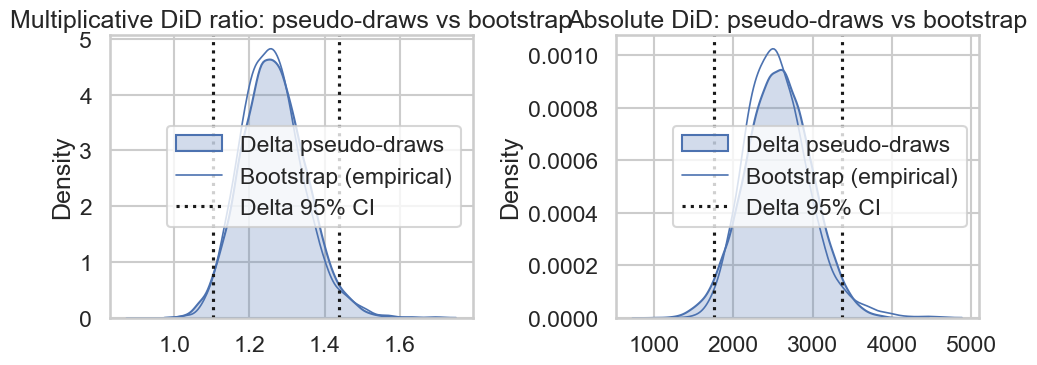

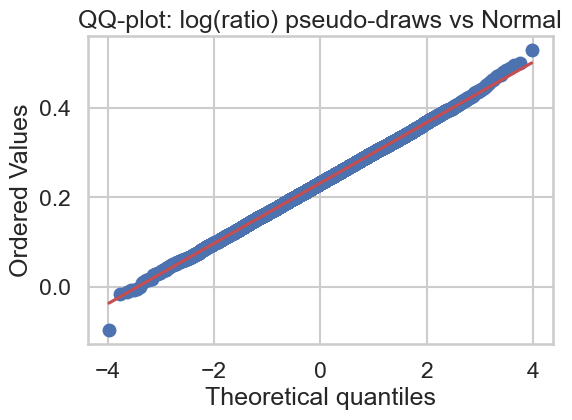

Empirical bootstrap coverage of delta 95% CI (ratio): 0.954
Empirical bootstrap coverage of delta 95% CI (abs):   0.956


{'summary_df':         method estimand   estimate  se_log     ci_low    ci_high        pval  \
 0  delta_ratio    ratio     1.2601  0.0673     1.1043     1.4379  5.9529e-04   
 1    delta_abs  abs_DiD  2563.1000     NaN  1755.8274  3370.3726  4.8802e-10   
 
          se  
 0       NaN  
 1  411.8813  ,
 'delta_ratio_res': {'ratio': 1.2601333352551505,
  'se_log': 0.06733674104059771,
  'ci_low': 1.1043312517445123,
  'ci_high': 1.4379164042607746,
  'z': 3.4337500363485396,
  'pval': 0.0005952928843819816,
  'varlog_Rw': 0.004380559641643985,
  'varlog_Re': 0.0001536770523245303},
 'delta_abs_res': {'DiD': 2563.1000000000004,
  'se': 411.881329702367,
  'ci_low': 1755.827427878893,
  'ci_high': 3370.3725721211076,
  'z': 6.222908918576483,
  'pval': 4.880207349344801e-10,
  'var_Dw': 168111.91527340817,
  'var_De': 1534.3144839817812},
 'draws': {'ratio_draws': array([1.13767813, 1.29571827, 1.19435264, ..., 1.26892958, 1.32277155,
         1.3494923 ]),
  'abs_draws': array([3142.323

In [15]:
# ---------- Run delta analytic + draws + diagnostics ----------
# 1) analytic estimates (delta)
ratio_res = multiplicative_DiD_delta_unpaired(
    mean_lc_w, sd_lc_w, n_lc_w,
    mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
    mean_lc_e, sd_lc_e, n_lc_e,
    mean_ctrl_e, sd_ctrl_e,
    z95=Z95
)

abs_res = absolute_DiD_delta_unpaired(
    mean_lc_w, sd_lc_w, n_lc_w,
    mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
    mean_lc_e, sd_lc_e, n_lc_e,
    mean_ctrl_e, sd_ctrl_e,
    z95=Z95
)

# 2) pseudo-draws for KDEs (use keyword args to avoid positional confusion)
draws = delta_pseudo_draws(
    mean_lc_w, sd_lc_w, n_lc_w,
    mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
    mean_lc_e, sd_lc_e, n_lc_e,
    mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
    ndraws=20000, seed=2025
)

# 3) parametric bootstrap (empirical sampling distribution)
boot = simulate_empirical_distribution_by_bootstrap(
    mean_lc_w, sd_lc_w, n_lc_w,
    mean_ctrl_w, sd_ctrl_w, n_ctrl_w,
    mean_lc_e, sd_lc_e, n_lc_e,
    mean_ctrl_e, sd_ctrl_e, n_ctrl_e,
    n_boot=2000, seed=2025, lognormal=True
)

# 4) Build summary DataFrame (analytic)
df = pd.DataFrame([
    {"method":"delta_ratio", "estimand":"ratio", "estimate": ratio_res["ratio"], "se_log": ratio_res["se_log"],
     "ci_low": ratio_res["ci_low"], "ci_high": ratio_res["ci_high"], "pval": ratio_res["pval"]},
    {"method":"delta_abs", "estimand":"abs_DiD", "estimate": abs_res["DiD"], "se": abs_res["se"],
     "ci_low": abs_res["ci_low"], "ci_high": abs_res["ci_high"], "pval": abs_res["pval"]}
])

pd.set_option("display.precision", 4)
print("\nDelta-method summary:")
print(df.to_string(index=False))

# ---------- Diagnostic plots ----------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.kdeplot(draws["ratio_draws"], fill=True, label="Delta pseudo-draws")
sns.kdeplot(boot["ratio_boot"], fill=False, lw=1.2, label="Bootstrap (empirical)")
plt.axvline(ratio_res["ci_low"], color='k', ls=':', label='Delta 95% CI')
plt.axvline(ratio_res["ci_high"], color='k', ls=':')
plt.title("Multiplicative DiD ratio: pseudo-draws vs bootstrap")
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(draws["abs_draws"], fill=True, label="Delta pseudo-draws")
sns.kdeplot(boot["abs_boot"], fill=False, lw=1.2, label="Bootstrap (empirical)")
plt.axvline(abs_res["ci_low"], color='k', ls=':', label='Delta 95% CI')
plt.axvline(abs_res["ci_high"], color='k', ls=':')
plt.title("Absolute DiD: pseudo-draws vs bootstrap")
plt.legend()

plt.tight_layout()
plt.show()

# QQ-plot for logratio (normality check)
plt.figure(figsize=(6,4))
lr = draws["logratio_draws"]
stats.probplot(lr, dist="norm", plot=plt)
plt.title("QQ-plot: log(ratio) pseudo-draws vs Normal")
plt.show()

# Empirical coverage check: proportion of bootstrap draws inside delta 95% CI
ratio_ci_low, ratio_ci_high = ratio_res["ci_low"], ratio_res["ci_high"]
abs_ci_low, abs_ci_high = abs_res["ci_low"], abs_res["ci_high"]
cov_ratio = np.mean((boot["ratio_boot"] >= ratio_ci_low) & (boot["ratio_boot"] <= ratio_ci_high))
cov_abs   = np.mean((boot["abs_boot"] >= abs_ci_low) & (boot["abs_boot"] <= abs_ci_high))

print(f"Empirical bootstrap coverage of delta 95% CI (ratio): {cov_ratio:.3f}")
print(f"Empirical bootstrap coverage of delta 95% CI (abs):   {cov_abs:.3f}")

# Return result dict for downstream plotting
results = {
    "summary_df": df,
    "delta_ratio_res": ratio_res,
    "delta_abs_res": abs_res,
    "draws": draws,
    "bootstrap": boot,
    "coverage": {"ratio": cov_ratio, "abs": cov_abs}
}
results


In [16]:
np.savez("DiD_bootstrap_results.npz", **boot)
np.savez("DiD_delta_pseudo_draws.npz", **draws)
df.to_csv("DiD_delta_summary.csv", index=False)
inputs = {
    "mean_lc_w": mean_lc_w, "sd_lc_w": sd_lc_w, "n_lc_w": n_lc_w,
    "mean_ctrl_w": mean_ctrl_w, "sd_ctrl_w": sd_ctrl_w, "n_ctrl_w": n_ctrl_w,
    "mean_lc_e": mean_lc_e, "sd_lc_e": sd_lc_e, "n_lc_e": n_lc_e,
    "mean_ctrl_e": mean_ctrl_e, "sd_ctrl_e": sd_ctrl_e, "n_ctrl_e": n_ctrl_e,
    "seed": 2025, "Z95": Z95
}
pd.DataFrame([inputs]).to_csv("DiD_inputs.csv", index=False)

Practical notes & diagnostics to watch

If the QQ plot is far from the line, or bootstrap density deviates a lot from Gaussian, the delta-method approximation may be poor — consider using Monte-Carlo simulation or a Bayesian approach.

If coverage is much lower than 0.95, the delta CI is anti-conservative (too narrow); if much larger, it’s overly conservative.

The parametric bootstrap result depends on the marginal family you assume to generate microdata (I used lognormal here). Try gamma as alternative to test sensitivity.

Watch denominators (control means): if any control mean is close to zero the ratio is unstable; you may want to present log-ratio and/or trim extreme draws.

For KDE plotting, use draws["ratio_draws"], draws["abs_draws"], or the bootstrap arrays if you prefer an empirical distribution.

# Section 2: Within Person Analysis: pre→post

## 1. Bayesian paired log-means model (MVN on log means) pre->post Design

This model works directly with the two observed log-means per country (post and pre) and their sampling covariance derived from sd, n and ρ. It produces full posterior draws for the true log-means, from which we can get folds, ratio and absolute DiD (on medians and, via posterior predictive aggregates, on means).

### 1. Gamma Marginals for posterior predictive microdata

In [101]:
# we prefer lognoraml given the high SD
# 2- Bayesian paired gamma model (MVN on log-means) + simulate individual-level Gamma marginal
import pymc as pm, arviz as az
import numpy as np, math
from scipy import stats

# ---------------------------
# Inputs (observed summaries)
# ---------------------------
mean_pre_w, sd_pre_w, n_w = 1555.1, 5337.1, 7923
mean_post_w, sd_post_w = 6681.6, 36188.3

mean_pre_e, sd_pre_e, n_e = 882.2, 3533.1, 295180
mean_post_e, sd_post_e = 3378.3, 21015.2

rho = 0.15
random_seed = 2025

# ---------------------------
# Helper: approximate sampling covariance of log(sample mean)
# (delta-method: Var(log(mean_hat)) ≈ Var(mean_hat)/mean^2, Var(mean_hat)=sd^2/n)
# For covariance between log mean_post and log mean_pre we use: cov ≈ rho * sd_post * sd_pre / (sqrt(n_post*n_pre) * mean_post * mean_pre)
# ---------------------------
def logmean_covariance(mean_post, sd_post, n_post, mean_pre, sd_pre, n_pre, rho):
    v_post = (sd_post**2) / (n_post * max(mean_post,1e-12)**2)
    v_pre  = (sd_pre**2)  / (n_pre * max(mean_pre,1e-12)**2)
    cov = rho * sd_post * sd_pre / (math.sqrt(n_post * n_pre) * max(mean_post,1e-12) * max(mean_pre,1e-12))
    return np.array([[v_post, cov],[cov, v_pre]])

obs_log_w = np.array([math.log(max(mean_post_w,1e-12)), math.log(max(mean_pre_w,1e-12))])
obs_log_e = np.array([math.log(max(mean_post_e,1e-12)), math.log(max(mean_pre_e,1e-12))])

cov_w = logmean_covariance(mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w, rho)
cov_e = logmean_covariance(mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e, rho)

# ---------------------------
# Bayesian paired log-means model
# ---------------------------
with pm.Model() as paired_log_model:
    # Weak priors for true log-means (non-hierarchical)
    mu_log_w = pm.Normal("mu_log_w", mu=obs_log_w, sigma=5.0, shape=2)  # [post, pre]
    mu_log_e = pm.Normal("mu_log_e", mu=obs_log_e, sigma=5.0, shape=2)

    # Observed log-means: MVN with known sampling covariance
    pm.MvNormal("obs_w", mu=mu_log_w, cov=cov_w, observed=obs_log_w)
    pm.MvNormal("obs_e", mu=mu_log_e, cov=cov_e, observed=obs_log_e)

    # Derived quantities (original scale)
    mean_w_post = pm.Deterministic("mean_w_post", pm.math.exp(mu_log_w[0]))
    mean_w_pre  = pm.Deterministic("mean_w_pre",  pm.math.exp(mu_log_w[1]))
    mean_e_post = pm.Deterministic("mean_e_post", pm.math.exp(mu_log_e[0]))
    mean_e_pre  = pm.Deterministic("mean_e_pre",  pm.math.exp(mu_log_e[1]))

    fold_W = pm.Deterministic("fold_W", pm.math.exp(mu_log_w[0] - mu_log_w[1]))
    fold_E = pm.Deterministic("fold_E", pm.math.exp(mu_log_e[0] - mu_log_e[1]))
    ratio = pm.Deterministic("ratio", fold_W / fold_E)
    abs_DiD = pm.Deterministic("abs_DiD",
                               (mean_w_post - mean_w_pre) - (mean_e_post - mean_e_pre))

    # Sampling -- adjust draws/tune
    idata_paired = pm.sample(draws=4000, tune=2000, chains=4, random_seed=random_seed,
                             target_accept=0.95, return_inferencedata=True)

# Flatten posterior draws for estimands (ready for KDE)
def flatten(idata, varname):
    return idata.posterior[varname].values.reshape(-1)

post_ratio = flatten(idata_paired, "ratio")
post_abs   = flatten(idata_paired, "abs_DiD")
post_fold_w = flatten(idata_paired, "fold_W")
post_fold_e = flatten(idata_paired, "fold_E")

# ---------------------------
# Plug-in Gamma shape (alpha) estimated from observed individual-level mean & sd for each group
# alpha_emp = mean^2 / var  (var = sd^2)
# ---------------------------
def empirical_gamma_alpha(mean, sd):
    var = max(sd**2, 1e-12)
    alpha = (mean**2) / var
    # enforce some floor to avoid numerical pathologies
    return max(alpha, 1e-6)

alpha_W_post = empirical_gamma_alpha(mean_post_w, sd_post_w)
alpha_W_pre  = empirical_gamma_alpha(mean_pre_w, sd_pre_w)
alpha_E_post = empirical_gamma_alpha(mean_post_e, sd_post_e)
alpha_E_pre  = empirical_gamma_alpha(mean_pre_e, sd_pre_e)

# ---------------------------
# Simulate individual-level Gamma microdata from posterior draws
# - choose a subset of posterior draws (n_post_draws_sim) to reduce compute and pool simulated individuals
# - for each draw: mean_draw = posterior mean (exp(mu_log)), shape = alpha_emp, scale = mean_draw / alpha_emp
# - draw n_indiv_per_draw individuals and pool
# ---------------------------
rng = np.random.default_rng(random_seed + 1)

# total number of simulated individuals you'd like per group for CCDF/PPC
sim_total_per_group = 50000

# number of posterior draws to use for simulation (tradeoff speed vs posterior coverage)
n_post_draws_sim = min(500, post_ratio.size)  # pick up to 500 posterior draws

# how many individuals per posterior draw
n_per_draw = max(1, sim_total_per_group // n_post_draws_sim)

# get indices of posterior draws to use (evenly spaced)
posterior_indices = np.linspace(0, post_ratio.size-1, n_post_draws_sim, dtype=int)

# storage (pooled simulated individuals)
sim_W_post = []
sim_W_pre  = []
sim_E_post = []
sim_E_pre  = []

# retrieve arrays of posterior means (flattened)
arr_mean_w_post = flatten(idata_paired, "mean_w_post")
arr_mean_w_pre  = flatten(idata_paired, "mean_w_pre")
arr_mean_e_post = flatten(idata_paired, "mean_e_post")
arr_mean_e_pre  = flatten(idata_paired, "mean_e_pre")

for idx in posterior_indices:
    m_w_post = arr_mean_w_post[idx]
    m_w_pre  = arr_mean_w_pre[idx]
    m_e_post = arr_mean_e_post[idx]
    m_e_pre  = arr_mean_e_pre[idx]

    # Gamma scale = mean / alpha
    scale_w_post = m_w_post / alpha_W_post if alpha_W_post>0 else m_w_post
    scale_w_pre  = m_w_pre  / alpha_W_pre  if alpha_W_pre>0  else m_w_pre
    scale_e_post = m_e_post / alpha_E_post if alpha_E_post>0 else m_e_post
    scale_e_pre  = m_e_pre  / alpha_E_pre  if alpha_E_pre>0  else m_e_pre

    # draw individuals (use numpy's gamma which uses shape k and scale theta)
    sim_W_post.append(rng.gamma(shape=alpha_W_post, scale=scale_w_post, size=n_per_draw))
    sim_W_pre.append(rng.gamma(shape=alpha_W_pre,  scale=scale_w_pre,  size=n_per_draw))
    sim_E_post.append(rng.gamma(shape=alpha_E_post, scale=scale_e_post, size=n_per_draw))
    sim_E_pre.append(rng.gamma(shape=alpha_E_pre,  scale=scale_e_pre,  size=n_per_draw))

# concatenate and trim to sim_total_per_group
sim_W_post = np.concatenate(sim_W_post)[:sim_total_per_group]
sim_W_pre  = np.concatenate(sim_W_pre)[:sim_total_per_group]
sim_E_post = np.concatenate(sim_E_post)[:sim_total_per_group]
sim_E_pre  = np.concatenate(sim_E_pre)[:sim_total_per_group]

# Package outputs for plotting and diagnostics
outputs = {
    "posterior_draws": {
        "ratio": post_ratio,
        "abs_DiD": post_abs,
        "fold_W": post_fold_w,
        "fold_E": post_fold_e
    },
    "simulated_individuals_gamma": {   # use for CCDF / tail plots / PPC
        "W_post": sim_W_post,
        "W_pre": sim_W_pre,
        "E_post": sim_E_post,
        "E_pre": sim_E_pre
    },
    "empirical_alpha": {
        "W_post": alpha_W_post, "W_pre": alpha_W_pre,
        "E_post": alpha_E_post, "E_pre": alpha_E_pre
    },
    "idata": idata_paired
}

summary_table = az.summary(idata_paired, var_names=["fold_W","fold_E","ratio","abs_DiD"], hdi_prob= 0.95)
display(summary_table)

# sim_W_post etc are now arrays you can feed to KDE / CCDF plotting functions.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_w, mu_log_e]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 45 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
fold_W,4.305,0.288,3.746,4.866,0.002,0.003,21168.000,12185.000,1.000
fold_E,3.829,0.049,3.735,3.924,0.000,0.000,18876.000,11391.000,1.000
ratio,1.125,0.077,0.976,1.274,0.001,0.001,20782.000,11993.000,1.000
abs_DiD,2641.976,405.980,1865.036,3458.218,2.862,3.451,20175.000,11908.000,1.000


### 2. Paired Bayesian log-means model + lognormal posterior predictive microdata

In [110]:
# paired_bayesian_lognormal_ppc_fixed.py
# Paired Bayesian log-means model + lognormal posterior predictive microdata
# Fixed bug in logmean_covariance and added empirical p-values to ArviZ summary

import os
import math
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid", context="talk")

# -----------------------------
# User inputs (observed summaries)
# -----------------------------
mean_pre_w, sd_pre_w, n_w = 1555.1, 5337.1, 7923
mean_post_w, sd_post_w = 6681.6, 36188.3

mean_pre_e, sd_pre_e, n_e = 882.2, 3533.1, 295180
mean_post_e, sd_post_e = 3378.3, 21015.2

rho = 0.15               # within-person correlation (pre/post)
random_seed = 2025

# Posterior sampling settings (tune these)
draws = 20000   # effective posterior draws per chain returned (flattened -> draws*chains)
tune = 5000
chains = 4
target_accept = 0.95

# For posterior predictive microdata simulation
sim_total_per_group = 50000   # total individuals to simulate per group for CCDF/PPC
n_post_draws_sim = 400        # how many posterior draws to use for simulation (trade-off speed/coverage)


# -----------------------------
# Helper functions
# -----------------------------
def logmean_covariance(mean_post, sd_post, n_post, mean_pre, sd_pre, n_pre, rho):
    """Approx sampling covariance of log(sample means) via delta-method.

    Var(log(mean_hat)) ≈ Var(mean_hat)/mean^2, Var(mean_hat) = sd^2 / n
    Cov(log mean_post, log mean_pre) ≈ rho * sd_post * sd_pre / (sqrt(n_post*n_pre) * mean_post * mean_pre)
    """
    mp = max(mean_post, 1e-12)
    pp = max(mean_pre, 1e-12)
    # CORRECTED: use n_post and n_pre (previous bug used az.summary_post by mistake)
    v_post = (sd_post**2) / (n_post * mp**2)
    v_pre  = (sd_pre**2)  / (n_pre  * pp**2)
    cov = rho * sd_post * sd_pre / (math.sqrt(n_post * n_pre) * mp * pp)
    mat = np.array([[v_post, cov], [cov, v_pre]])
    # numerical stabilization
    mat = (mat + mat.T) / 2.0
    mat += np.eye(2) * 1e-12
    return mat


def flatten(idata, varname):
    """Return flattened posterior draws for varname as 1D numpy array."""
    arr = idata.posterior[varname].values
    return arr.reshape(-1)


def empirical_lognormal_sigma_from_sample(mean_obs, sd_obs):
    """Return lognormal sigma (sd on log-scale) using observed mean & sd via sigma^2 = log1p(cv^2)."""
    m = max(mean_obs, 1e-12)
    s = max(sd_obs, 1e-12)
    cv2 = (s/m)**2
    sigma2 = math.log1p(cv2)
    return math.sqrt(max(sigma2, 0.0))


# -----------------------------
# Build & sample Bayesian paired log-means model
# -----------------------------
obs_log_w = np.array([math.log(max(mean_post_w,1e-12)), math.log(max(mean_pre_w,1e-12))])
obs_log_e = np.array([math.log(max(mean_post_e,1e-12)), math.log(max(mean_pre_e,1e-12))])

cov_w = logmean_covariance(mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w, rho)
cov_e = logmean_covariance(mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e, rho)

with pm.Model() as paired_log_model:
    # Weak priors on true log-means (two-element vectors: [post, pre])
    mu_log_w = pm.Normal("mu_log_w", mu=obs_log_w, sigma=5.0, shape=2)
    mu_log_e = pm.Normal("mu_log_e", mu=obs_log_e, sigma=5.0, shape=2)

    # Observed sample log-means ~ MVN (known sampling covariance)
    pm.MvNormal("obs_w", mu=mu_log_w, cov=cov_w, observed=obs_log_w)
    pm.MvNormal("obs_e", mu=mu_log_e, cov=cov_e, observed=obs_log_e)

    # Deterministic transforms (original scale)
    mean_w_post = pm.Deterministic("mean_w_post", pm.math.exp(mu_log_w[0]))
    mean_w_pre  = pm.Deterministic("mean_w_pre",  pm.math.exp(mu_log_w[1]))
    mean_e_post = pm.Deterministic("mean_e_post", pm.math.exp(mu_log_e[0]))
    mean_e_pre  = pm.Deterministic("mean_e_pre",  pm.math.exp(mu_log_e[1]))

    fold_W = pm.Deterministic("fold_W", pm.math.exp(mu_log_w[0] - mu_log_w[1]))
    fold_E = pm.Deterministic("fold_E", pm.math.exp(mu_log_e[0] - mu_log_e[1]))
    ratio   = pm.Deterministic("ratio", fold_W / fold_E)
    abs_DiD = pm.Deterministic("abs_DiD",
                               (mean_w_post - mean_w_pre) - (mean_e_post - mean_e_pre))

    idata_paired = pm.sample(draws=draws, tune=tune, chains=chains,
                             random_seed=random_seed, target_accept=target_accept,
                             return_inferencedata=True)


# -----------------------------
# Extract posterior draws (flattened)
# -----------------------------
post_ratio = flatten(idata_paired, "ratio")
post_abs   = flatten(idata_paired, "abs_DiD")
post_fold_w = flatten(idata_paired, "fold_W")
post_fold_e = flatten(idata_paired, "fold_E")

# ArviZ summary
summary_table = az.summary(idata_paired, var_names=["fold_W","fold_E","ratio","abs_DiD"], hdi_prob=.95)
#print("\nArviZ posterior summary:")
#display(summary_table)


# -----------------------------
# Posterior "p-values" (posterior probabilities)
# -----------------------------
def bayesian_pvals_from_draws(ratio_draws, abs_draws):
    # ratio: null = 1 (no multiplicative difference)
    prob_ratio_gt1 = np.mean(ratio_draws > 1.0)
    prob_ratio_lt1 = np.mean(ratio_draws < 1.0)
    two_sided_ratio = 2.0 * min(prob_ratio_gt1, prob_ratio_lt1)

    # abs: null = 0
    prob_abs_gt0 = np.mean(abs_draws > 0.0)
    prob_abs_lt0 = np.mean(abs_draws < 0.0)
    two_sided_abs = 2.0 * min(prob_abs_gt0, prob_abs_lt0)

    return {
        "P(ratio>1)": float(prob_ratio_gt1),
        "P(ratio<1)": float(prob_ratio_lt1),
        "p_two_sided_ratio": float(two_sided_ratio),
        "P(abs>0)": float(prob_abs_gt0),
        "P(abs<0)": float(prob_abs_lt0),
        "p_two_sided_abs": float(two_sided_abs)
    }

pvals = bayesian_pvals_from_draws(post_ratio, post_abs)
#print("\nBayesian posterior tail probabilities (report instead of classical p-values):")
#print(pvals)


# -----------------------------
# Simulate individual-level lognormal microdata from posterior draws
# -----------------------------
rng = np.random.default_rng(random_seed + 1)

# empirical log-sigmas from observed data (keeps microdata variance aligned with observed CV)
sigma_w_post = empirical_lognormal_sigma_from_sample(mean_post_w, sd_post_w)
sigma_w_pre  = empirical_lognormal_sigma_from_sample(mean_pre_w, sd_pre_w)
sigma_e_post = empirical_lognormal_sigma_from_sample(mean_post_e, sd_post_e)
sigma_e_pre  = empirical_lognormal_sigma_from_sample(mean_pre_e, sd_pre_e)

# get flattened arrays of mean draws (posterior)
arr_mean_w_post = flatten(idata_paired, "mean_w_post")
arr_mean_w_pre  = flatten(idata_paired, "mean_w_pre")
arr_mean_e_post = flatten(idata_paired, "mean_e_post")
arr_mean_e_pre  = flatten(idata_paired, "mean_e_pre")

# choose posterior draws to use for simulation (evenly spaced indices)
n_total_draws = arr_mean_w_post.size
n_use = min(n_post_draws_sim, n_total_draws)
indices = np.linspace(0, n_total_draws-1, n_use, dtype=int)

# how many individuals per posterior-draw to reach desired total per group
n_per_draw = max(1, sim_total_per_group // n_use)

sim_W_post = []
sim_W_pre  = []
sim_E_post = []
sim_E_pre  = []

for idx in indices:
    m_w_post = float(arr_mean_w_post[idx])
    m_w_pre  = float(arr_mean_w_pre[idx])
    m_e_post = float(arr_mean_e_post[idx])
    m_e_pre  = float(arr_mean_e_pre[idx])

    # compute lognormal mu (on log scale) so that E[X] = m_draw with sigma fixed
    mu_w_post = math.log(max(m_w_post, 1e-12)) - 0.5 * sigma_w_post**2
    mu_w_pre  = math.log(max(m_w_pre, 1e-12))  - 0.5 * sigma_w_pre**2
    mu_e_post = math.log(max(m_e_post, 1e-12)) - 0.5 * sigma_e_post**2
    mu_e_pre  = math.log(max(m_e_pre, 1e-12))  - 0.5 * sigma_e_pre**2

    sim_W_post.append(rng.lognormal(mean=mu_w_post, sigma=sigma_w_post, size=n_per_draw))
    sim_W_pre.append(rng.lognormal(mean=mu_w_pre,  sigma=sigma_w_pre,  size=n_per_draw))
    sim_E_post.append(rng.lognormal(mean=mu_e_post, sigma=sigma_e_post, size=n_per_draw))
    sim_E_pre.append(rng.lognormal(mean=mu_e_pre,  sigma=sigma_e_pre,  size=n_per_draw))

# pool & trim to exact totals
sim_W_post = np.concatenate(sim_W_post)[:sim_total_per_group]
sim_W_pre  = np.concatenate(sim_W_pre)[:sim_total_per_group]
sim_E_post = np.concatenate(sim_E_post)[:sim_total_per_group]
sim_E_pre  = np.concatenate(sim_E_pre)[:sim_total_per_group]

print("\nSimulated individuals per group (lognormal marginals):", sim_W_post.size, sim_W_pre.size, sim_E_post.size, sim_E_pre.size)


# -----------------------------
# Simple diagnostic PPC: check observed sample means vs posterior predictive sample-mean distribution
# -----------------------------
def ppc_sample_mean_distribution(n_ppc_draws=2000):
    rng_loc = np.random.default_rng(random_seed + 2)
    ppc_means = {"W_post": [], "W_pre": [], "E_post": [], "E_pre": []}
    for idx in indices[:min(n_ppc_draws, len(indices))]:
        m_w_post = float(arr_mean_w_post[idx])
        m_w_pre  = float(arr_mean_w_pre[idx])
        m_e_post = float(arr_mean_e_post[idx])
        m_e_pre  = float(arr_mean_e_pre[idx])

        mu_w_post = math.log(max(m_w_post, 1e-12)) - 0.5 * sigma_w_post**2
        mu_w_pre  = math.log(max(m_w_pre, 1e-12))  - 0.5 * sigma_w_pre**2
        mu_e_post = math.log(max(m_e_post, 1e-12)) - 0.5 * sigma_e_post**2
        mu_e_pre  = math.log(max(m_e_pre, 1e-12))  - 0.5 * sigma_e_pre**2

        x_w_post = rng_loc.lognormal(mean=mu_w_post, sigma=sigma_w_post, size=n_w)
        x_w_pre  = rng_loc.lognormal(mean=mu_w_pre,  sigma=sigma_w_pre,  size=n_w)
        x_e_post = rng_loc.lognormal(mean=mu_e_post, sigma=sigma_e_post, size=n_e)
        x_e_pre  = rng_loc.lognormal(mean=mu_e_pre,  sigma=sigma_e_pre,  size=n_e)

        ppc_means["W_post"].append(x_w_post.mean())
        ppc_means["W_pre"].append(x_w_pre.mean())
        ppc_means["E_post"].append(x_e_post.mean())
        ppc_means["E_pre"].append(x_e_pre.mean())

    for k in list(ppc_means.keys()):
        ppc_means[k] = np.array(ppc_means[k])
    return ppc_means

ppc_means = ppc_sample_mean_distribution(n_ppc_draws=400)

def ppc_report(ppc_arr, obs):
    qlo, qhi = np.percentile(ppc_arr, [2.5,97.5])
    median = np.median(ppc_arr)
    return {"obs":obs, "ppc_median":median, "ppc_2.5%":qlo, "ppc_97.5%":qhi}

ppc_report_W_post = ppc_report(ppc_means["W_post"], mean_post_w)
ppc_report_W_pre  = ppc_report(ppc_means["W_pre"],  mean_pre_w)
ppc_report_E_post = ppc_report(ppc_means["E_post"], mean_post_e)
ppc_report_E_pre  = ppc_report(ppc_means["E_pre"],  mean_pre_e)

print("\nPPC (observed mean vs posterior predictive sample-mean intervals):")
print("W post:", ppc_report_W_post)
print("W pre: ", ppc_report_W_pre)
print("E post:", ppc_report_E_post)
print("E pre: ", ppc_report_E_pre)


# -----------------------------
# Add empirical posterior tail probs & empirical p-values to ArviZ summary
# -----------------------------
def empirical_two_sided_pval_from_draws(draws, null=0.0, correction=True):
    arr = np.asarray(draws)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    n = arr.size
    le = np.sum(arr <= null)
    ge = np.sum(arr >= null)
    if correction:
        p_le = (le + 1) / (n + 1)
        p_ge = (ge + 1) / (n + 1)
    else:
        p_le = le / n
        p_ge = ge / n
    p = 2.0 * min(p_le, p_ge)
    return float(min(max(p, 0.0), 1.0))

def posterior_tail_probs(draws, null=0.0):
    arr = np.asarray(draws)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return {"P_gt": np.nan, "P_lt": np.nan, "p_emp": np.nan}
    P_gt = np.mean(arr > null)
    P_lt = np.mean(arr < null)
    p_emp = empirical_two_sided_pval_from_draws(arr, null=null, correction=True)
    return {"P_gt": float(P_gt), "P_lt": float(P_lt), "p_emp": float(p_emp)}

post_draws_map = {
    "fold_W": {"draws": post_fold_w, "null": 1.0},
    "fold_E": {"draws": post_fold_e, "null": 1.0},
    "ratio" : {"draws": post_ratio,  "null": 1.0},
    "abs_DiD": {"draws": post_abs,   "null": 0.0}
}

aug_summary = summary_table.copy()
for varname, info in post_draws_map.items():
    draws = info["draws"]
    null = info["null"]
    probs = posterior_tail_probs(draws, null=null)
    # If row doesn't exist (rare), create it
    if varname not in aug_summary.index:
        aug_summary.loc[varname] = np.nan
    aug_summary.loc[varname, "p_empirical"] = probs["p_emp"]
    aug_summary.loc[varname, "P_gt_null"]   = probs["P_gt"]
    aug_summary.loc[varname, "P_lt_null"]   = probs["P_lt"]
    aug_summary.loc[varname, "null_value"] = null

print("\nAugmented ArviZ posterior summary (added empirical p-values & tail probs):")
display(aug_summary)

# -----------------------------
# Package outputs for plotting functions / downstream analysis
# -----------------------------
outputs = {
    "posterior_draws": {
        "ratio": post_ratio,
        "abs_DiD": post_abs,
        "fold_W": post_fold_w,
        "fold_E": post_fold_e
    },
    "simulated_individuals_lognormal": {
        "W_post": sim_W_post, "W_pre": sim_W_pre,
        "E_post": sim_E_post, "E_pre": sim_E_pre
    },
    "arviz_summary": summary_table,
    "augmented_arviz_summary": aug_summary,
    "bayesian_pvals": pvals,
    "ppc_means": {
        "W_post": ppc_means["W_post"], "W_pre": ppc_means["W_pre"],
        "E_post": ppc_means["E_post"], "E_pre": ppc_means["E_pre"]
    },
    "idata": idata_paired
}

print("\nAll done. 'outputs' dict contains posterior draws, simulated individuals, summaries, ppc results and idata.")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_w, mu_log_e]


Output()

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 78 seconds.



Simulated individuals per group (lognormal marginals): 50000 50000 50000 50000

PPC (observed mean vs posterior predictive sample-mean intervals):
W post: {'obs': 6681.6, 'ppc_median': 6711.138810345903, 'ppc_2.5%': 5728.232234891673, 'ppc_97.5%': 7919.695801838496}
W pre:  {'obs': 1555.1, 'ppc_median': 1552.5356522364223, 'ppc_2.5%': 1407.8385023108794, 'ppc_97.5%': 1724.9216128908893}
E post: {'obs': 3378.3, 'ppc_median': 3380.220927526545, 'ppc_2.5%': 3283.962876583822, 'ppc_97.5%': 3511.6502959488203}
E pre:  {'obs': 882.2, 'ppc_median': 882.8747101124181, 'ppc_2.5%': 864.1462341005838, 'ppc_97.5%': 901.036319239859}

Augmented ArviZ posterior summary (added empirical p-values & tail probs):


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,p_empirical,P_gt_null,P_lt_null,null_value
fold_W,4.305,0.288,3.756,4.883,0.001,0.001,104862.000,61335.000,1.000,0.000,1.000,0.000,1.000
fold_E,3.830,0.049,3.734,3.924,0.000,0.000,93552.000,59432.000,1.000,0.000,1.000,0.000,1.000
ratio,1.124,0.077,0.977,1.275,0.000,0.000,105132.000,61743.000,1.000,0.092,0.954,0.046,1.000
abs_DiD,2639.671,404.780,1872.021,3449.995,1.271,1.452,101589.000,62098.000,1.000,0.000,1.000,0.000,0.000



All done. 'outputs' dict contains posterior draws, simulated individuals, summaries, ppc results and idata.


### 3. Visualisation

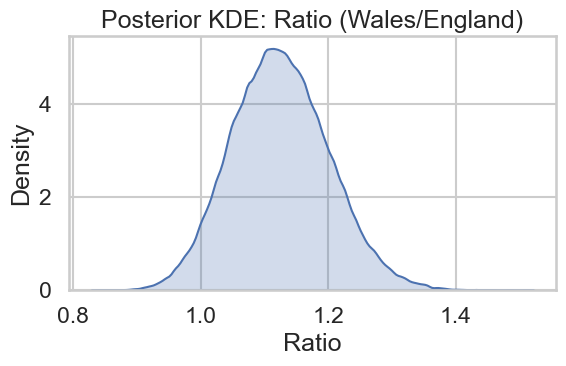

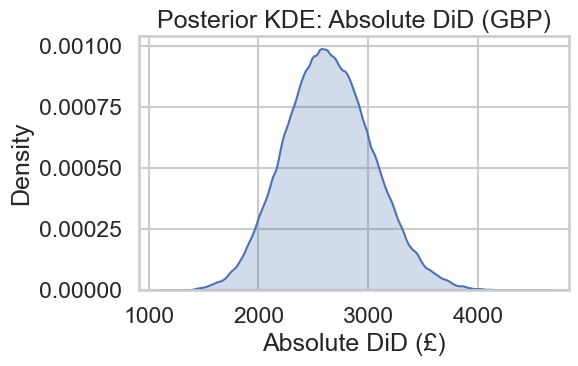

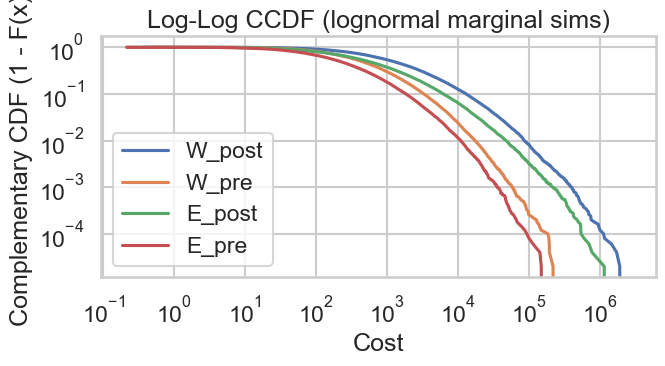

In [112]:
plot_kde_samples(post_ratio, "Posterior KDE: Ratio (Wales/England)", "Ratio")
plot_kde_samples(post_abs,   "Posterior KDE: Absolute DiD (GBP)", "Absolute DiD (£)")
plot_ccdf_from_samples_dict(outputs["simulated_individuals_lognormal"], title="Log-Log CCDF (lognormal marginal sims)")

## 2. Monte-Carlo microdata reconstruction (Gaussian copula)

simulate individual-level Gamma microdata from the posterior draws of the paired log-means model

In [81]:
# --- Extended Monte Carlo DiD copula with p-values and plotting ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import gaussian_kde
sns.set(style="whitegrid")

def montecarlo_did_copula_prepost_refined(
    mean_pre_w, sd_pre_w, n_w, mean_post_w, sd_post_w,
    mean_pre_e, sd_pre_e, n_e, mean_post_e, sd_post_e,
    rho=0.15, marginal='lognormal', n_mc=3000, seed=2025, max_indiv_sim=20000
):
    rng = np.random.default_rng(seed)
    # prepare params
    if marginal=='lognormal':
        def log_params(m,s): 
            var = s**2; sigma2 = math.log1p(var/(m**2)); sigma=math.sqrt(max(sigma2,0.0)); mu=math.log(max(m,1e-12)) - 0.5*sigma2
            return mu, sigma
        mu_pre_w, sigma_pre_w = log_params(mean_pre_w, sd_pre_w)
        mu_post_w, sigma_post_w = log_params(mean_post_w, sd_post_w)
        mu_pre_e, sigma_pre_e = log_params(mean_pre_e, sd_pre_e)
        mu_post_e, sigma_post_e = log_params(mean_post_e, sd_post_e)
    else:
        def gamma_params(m,s):
            var = s**2
            m = max(m,1e-12); var = max(var,1e-12)
            a = m**2/var; scale = var/m
            return a, scale
        a_pre_w, th_pre_w = gamma_params(mean_pre_w, sd_pre_w)
        a_post_w, th_post_w = gamma_params(mean_post_w, sd_post_w)
        a_pre_e, th_pre_e = gamma_params(mean_pre_e, sd_pre_e)
        a_post_e, th_post_e = gamma_params(mean_post_e, sd_post_e)

    simulate_wales_micro = (n_w <= max_indiv_sim)

    ratio_draws = np.empty(n_mc)
    abs_draws = np.empty(n_mc)
    fold_w = np.empty(n_mc)
    fold_e = np.empty(n_mc)

    # England CLT cov (on original means)
    var_mean_post_e = (sd_post_e**2)/n_e
    var_mean_pre_e  = (sd_pre_e**2)/n_e
    cov_means_e = rho * sd_post_e * sd_pre_e / n_e
    cov_mat_e = np.array([[var_mean_post_e, cov_means_e],[cov_means_e, var_mean_pre_e]])

    for it in trange(n_mc, desc=f"MC {marginal} rho={rho:.3f}"):
        # Wales
        if simulate_wales_micro:
            z1 = rng.standard_normal(n_w)
            z2 = rng.standard_normal(n_w)
            z2corr = rho*z1 + math.sqrt(max(0.0,1-rho**2))*z2
            if marginal=='lognormal':
                pre_w = np.exp(mu_pre_w + sigma_pre_w * z1)
                post_w = np.exp(mu_post_w + sigma_post_w * z2corr)
            else:
                u1 = stats.norm.cdf(z1); u2 = stats.norm.cdf(z2corr)
                pre_w = stats.gamma.ppf(u1, a=a_pre_w, scale=th_pre_w)
                post_w = stats.gamma.ppf(u2, a=a_post_w, scale=th_post_w)
            mean_pre_w_sim = pre_w.mean(); mean_post_w_sim = post_w.mean()
        else:
            var_post_mean_w = (sd_post_w**2)/n_w
            var_pre_mean_w  = (sd_pre_w**2)/n_w
            cov_means_w = rho * sd_post_w * sd_pre_w / n_w
            cov_mat_w = np.array([[var_post_mean_w, cov_means_w],[cov_means_w, var_pre_mean_w]])
            xy = rng.multivariate_normal([mean_post_w, mean_pre_w], cov=cov_mat_w)
            mean_post_w_sim, mean_pre_w_sim = xy[0], xy[1]

        # England sample-means (CLT)
        xy_e = rng.multivariate_normal([mean_post_e, mean_pre_e], cov=cov_mat_e)
        mean_post_e_sim, mean_pre_e_sim = xy_e[0], xy_e[1]

        # estimands
        fw = mean_post_w_sim / max(mean_pre_w_sim, 1e-12)
        fe = mean_post_e_sim / max(mean_pre_e_sim, 1e-12)
        ratio_draws[it] = fw / fe
        fold_w[it] = fw; fold_e[it] = fe
        abs_draws[it] = (mean_post_w_sim - mean_pre_w_sim) - (mean_post_e_sim - mean_pre_e_sim)

    # summarise with p-values
    def summar(x, null=0.0, log=False):
        if log:  # for ratio test null=1
            pval = 2*min(np.mean(x<=1.0), np.mean(x>=1.0))
        else:
            pval = 2*min(np.mean(x<=null), np.mean(x>=null))
        return {
            "mean": np.nanmean(x),
            "sd": np.nanstd(x, ddof=1),
            "2.5%": np.nanpercentile(x,2.5),
            "97.5%": np.nanpercentile(x,97.5),
            "pval": pval
        }

    summary = {
        "ratio": summar(ratio_draws, null=1.0, log=True),
        "abs": summar(abs_draws, null=0.0, log=False),
        "fold_w": summar(fold_w),
        "fold_e": summar(fold_e)
    }

    return {"ratio": ratio_draws, "abs": abs_draws, "fold_w": fold_w, "fold_e": fold_e}, summary


# === Run example ===
draws_mc, summary_mc = montecarlo_did_copula_prepost_refined(
    mean_pre_w, sd_pre_w, n_w, mean_post_w, sd_post_w,
    mean_pre_e, sd_pre_e, n_e, mean_post_e, sd_post_e,
    rho=0.15, marginal='lognormal', n_mc=50000, seed=2025, max_indiv_sim=20000
)

def empirical_two_sided_pval(draws, null=0.0, correction=True):
    arr = np.asarray(draws)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    n = arr.size
    le = np.sum(arr <= null)
    ge = np.sum(arr >= null)
    if correction:
        p_le = (le + 1) / (n + 1)
        p_ge = (ge + 1) / (n + 1)
    else:
        p_le = le / n
        p_ge = ge / n
    p = 2.0 * min(p_le, p_ge)
    return float(min(max(p, 0.0), 1.0))

# Build tidy summary df with empirical p-values
ratio_draws = draws_mc["ratio"]
abs_draws = draws_mc["abs"]
fold_w = draws_mc["fold_w"]
fold_e = draws_mc["fold_e"]



def summar_dict(x):
    return {
        "mean": float(np.nanmean(x)),
        "sd": float(np.nanstd(x, ddof=1)),
        "ci_low": float(np.nanpercentile(x, 2.5)),
        "ci_high": float(np.nanpercentile(x, 97.5)),
        "p_empirical": empirical_two_sided_pval(x, null=1.0) if np.nanmean(x)>0 else np.nan
    }

summary_rows = [
    {"estimand":"ratio", **summar_dict(ratio_draws), "null":1.0, "type":"multiplicative"},
    {"estimand":"abs_DiD", **summar_dict(abs_draws), "null":0.0, "type":"absolute"},
    {"estimand":"fold_w", **summar_dict(fold_w), "null":1.0, "type":"multiplicative"},
    {"estimand":"fold_e", **summar_dict(fold_e), "null":1.0, "type":"multiplicative"}
]
summary_df = pd.DataFrame(summary_rows)
# correct p-value logic for ratio (null=1) and abs (null=0)
summary_df.loc[summary_df["estimand"]=="ratio", "p_empirical"] = empirical_two_sided_pval(ratio_draws, null=1.0)
summary_df.loc[summary_df["estimand"]=="abs_DiD", "p_empirical"] = empirical_two_sided_pval(abs_draws, null=0.0)


# Set display precision globally (3 decimal places)
pd.set_option('display.float_format', '{:.3f}'.format)
summary_df


MC lognormal rho=0.150: 100%|███████████████| 50000/50000 [00:35<00:00, 1409.60it/s]


,estimand,mean,sd,ci_low,ci_high,p_empirical,null,type
0,ratio,1.123,0.081,0.984,1.295,0.089,1.000,multiplicative
1,abs_DiD,2628.407,412.092,1961.945,3526.545,0.000,0.000,absolute
2,fold_w,4.301,0.306,3.775,4.949,0.000,1.000,multiplicative
3,fold_e,3.830,0.049,3.735,3.926,0.000,1.000,multiplicative


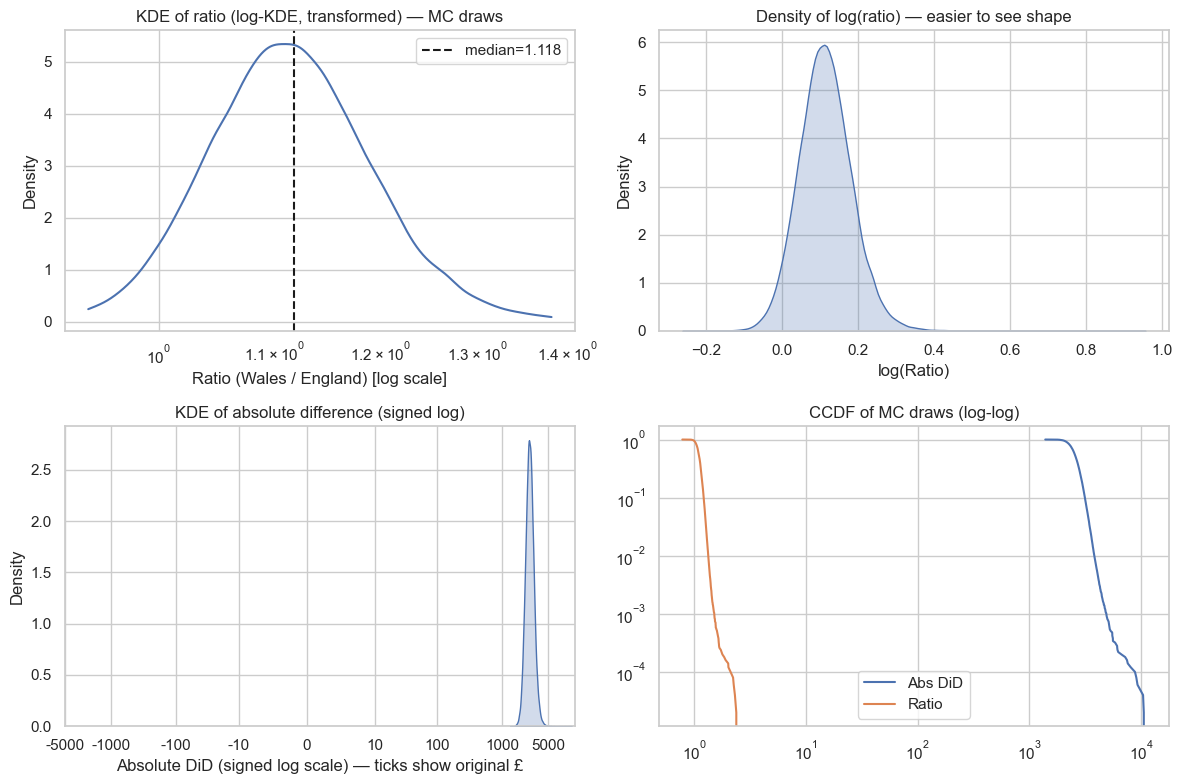

estimand     mean      sd   ci_low  ci_high  p_empirical  null           type
   ratio    1.123   0.081    0.984    1.295        0.089 1.000 multiplicative
 abs_DiD 2628.407 412.092 1961.945 3526.545        0.000 0.000       absolute
  fold_w    4.301   0.306    3.775    4.949        0.000 1.000 multiplicative
  fold_e    3.830   0.049    3.735    3.926        0.000 1.000 multiplicative


In [82]:
# 1) Ratio: compute KDE in log-space then transform density back to original scale
def density_from_log_kde(draws, x_min=None, x_max=None, npoints=800, bw_adjust=1.0):
    pos = draws[~np.isnan(draws) & (draws>0)]
    logpos = np.log(pos)
    kde_log = gaussian_kde(logpos)
    kde_log.set_bandwidth(kde_log.factor * bw_adjust)
    if x_min is None: x_min = np.exp(np.percentile(logpos, 0.5))   # avoid zero
    if x_max is None: x_max = np.exp(np.percentile(logpos, 99.5))
    xs = np.exp(np.linspace(np.log(max(1e-9, x_min)), np.log(x_max), npoints))
    log_xs = np.log(xs)
    dens_log = kde_log(log_xs)            # density in log-space
    dens_x = dens_log / xs                # change-of-variable f_X(x)=f_Y(log x)/x
    return xs, dens_x

# 2) Absolute DiD: signed log transform for plotting
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))
def inv_signed_log(s):
    return np.sign(s) * (np.expm1(np.abs(s)))

# plotting
fig, axes = plt.subplots(2,2, figsize=(12,8))

# Ratio KDE: plot on original scale but produced via log-kde (good for multiplicative)
ax = axes[0,0]
xs, dens_x = density_from_log_kde(ratio_draws, bw_adjust=1.0, npoints=1200)
ax.plot(xs, dens_x, color="C0", lw=1.5)
ax.set_xscale("log")
ax.set_xlabel("Ratio (Wales / England) [log scale]")
ax.set_ylabel("Density")
ax.set_title("KDE of ratio (log-KDE, transformed) — MC draws")
ax.axvline(np.median(ratio_draws), color="k", ls="--", label=f"median={np.median(ratio_draws):.3f}")
ax.legend()

# Ratio KDE on log scale (optional): density of log(ratio)
ax = axes[0,1]
sns.kdeplot(np.log(ratio_draws), fill=True, ax=ax, bw_adjust=1.0)
ax.set_xlabel("log(Ratio)")
ax.set_title("Density of log(ratio) — easier to see shape")

# Absolute DiD: signed log KDE
ax = axes[1,0]
svals = signed_log(abs_draws)
sns.kdeplot(svals, fill=True, ax=ax, bw_adjust=1.0)
# place tick labels back to original values at some positions
tick_orig = np.array([-5000, -1000, -100, -10, 0, 10, 100, 1000, 5000])
tick_s = signed_log(tick_orig)
ax.set_xticks(tick_s)
ax.set_xticklabels([str(int(t)) for t in tick_orig])
ax.set_xlabel("Absolute DiD (signed log scale) — ticks show original £")
ax.set_title("KDE of absolute difference (signed log)")

# CCDFs (log-log) for tails: absolute and ratio (for ratio we plot CCDF of fold_w and fold_e instead)
ax = axes[1,1]
def ccdf_plot(data, label, ax, xscale="log"):
    x = np.sort(data[~np.isnan(data)])
    y = 1.0 - np.arange(1, len(x)+1)/len(x)
    if xscale == "log":
        ax.loglog(x, y, label=label)
    else:
        ax.plot(x, y, label=label)

# CCDF of individual-simulated microdata could be more informative; but we plot the MC draws CCDFs:
ccdf_plot(abs_draws, "Abs DiD", ax, xscale="log")
ccdf_plot(ratio_draws, "Ratio", ax, xscale="log")
ax.legend(); ax.set_title("CCDF of MC draws (log-log)")

plt.tight_layout()
plt.show()

# Print tidy summary
print(summary_df.to_string(index=False))


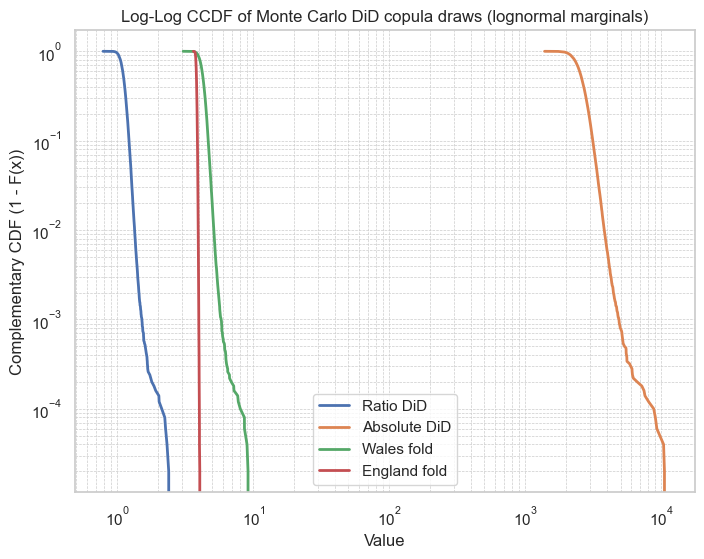

In [84]:
# --- CCDF plotting for Monte Carlo DiD copula draws ---

def plot_ccdf_did_extended(draws_mc):
    plt.figure(figsize=(8,6))
    for key, arr in [
        ("Ratio DiD", draws_mc["ratio"]),
        ("Absolute DiD", draws_mc["abs"]),
        ("Wales fold", draws_mc["fold_w"]),
        ("England fold", draws_mc["fold_e"])
    ]:
        arr = np.asarray(arr)
        arr = arr[~np.isnan(arr)]
        arr_sorted = np.sort(arr)
        ccdf = 1.0 - np.arange(1, len(arr_sorted)+1) / len(arr_sorted)
        plt.loglog(arr_sorted, ccdf, label=key, lw=2)
    plt.xlabel("Value")
    plt.ylabel("Complementary CDF (1 - F(x))")
    plt.title("Log-Log CCDF of Monte Carlo DiD copula draws (lognormal marginals)")
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.show()

plot_ccdf_did_extended(draws_mc)


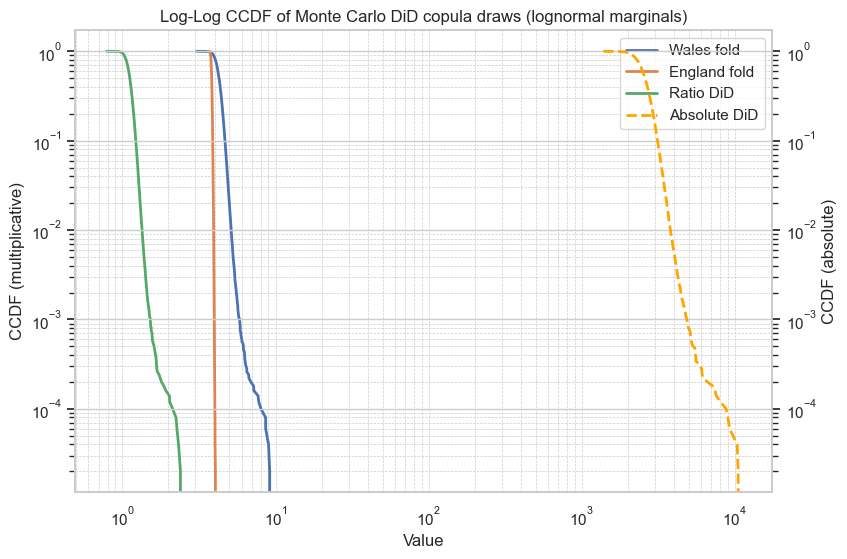

In [86]:
def plot_ccdf_did_combined(draws_mc):
    fig, ax1 = plt.subplots(figsize=(9,6))

    # --- Axis 1: multiplicative scales ---
    for key, arr in [
        ("Wales fold", draws_mc["fold_w"]),
        ("England fold", draws_mc["fold_e"]),
        ("Ratio DiD", draws_mc["ratio"]),
    ]:
        arr = np.asarray(arr)
        arr = arr[~np.isnan(arr)]
        arr_sorted = np.sort(arr)
        ccdf = 1.0 - np.arange(1, len(arr_sorted)+1) / len(arr_sorted)
        ax1.loglog(arr_sorted, ccdf, label=key, lw=2)

    ax1.set_xlabel("Value")
    ax1.set_ylabel("CCDF (multiplicative)")
    ax1.grid(True, which="both", ls="--", lw=0.5)

    # --- Axis 2: additive scale (absolute DiD) ---
    ax2 = ax1.twinx()
    arr = np.asarray(draws_mc["abs"])
    arr = arr[~np.isnan(arr)]
    arr_sorted = np.sort(arr)
    ccdf = 1.0 - np.arange(1, len(arr_sorted)+1) / len(arr_sorted)
    ax2.loglog(arr_sorted, ccdf, color="orange", lw=2, ls="--", label="Absolute DiD")

    ax2.set_ylabel("CCDF (absolute)")
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc="upper right")

    plt.title("Log-Log CCDF of Monte Carlo DiD copula draws (lognormal marginals)")
    plt.show()

    
plot_ccdf_did_combined(draws_mc)

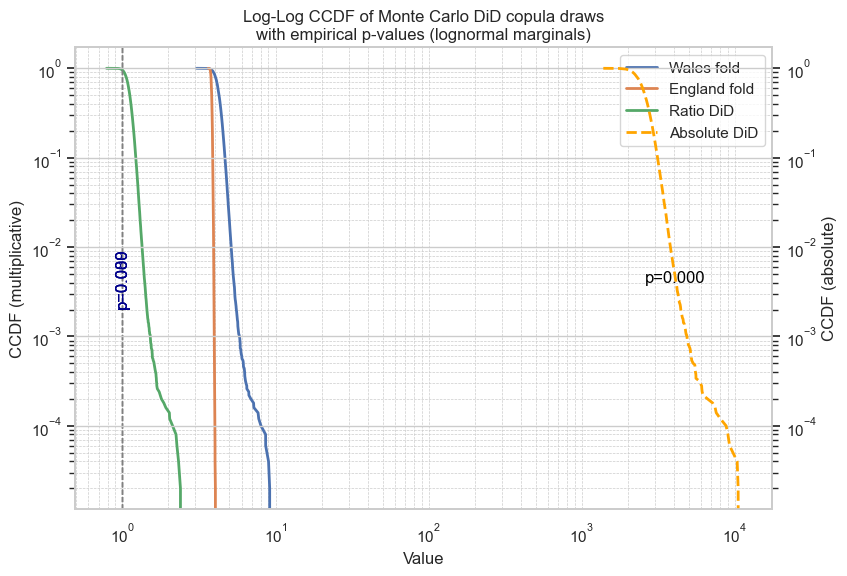

In [94]:
def plot_ccdf_did_combined_with_p(draws_mc):
    fig, ax1 = plt.subplots(figsize=(9,6))
    # --- Axis 1: multiplicative estimands ---
    for key, arr, null in [
        ("Wales fold", draws_mc["fold_w"], 1.0),
        ("England fold", draws_mc["fold_e"], 1.0),
        ("Ratio DiD", draws_mc["ratio"], 1.0),
    ]:
        arr = np.asarray(arr)
        arr = arr[~np.isnan(arr)]
        arr_sorted = np.sort(arr)
        ccdf = 1.0 - np.arange(1, len(arr_sorted)+1) / len(arr_sorted)
        ax1.loglog(arr_sorted, ccdf, label=key, lw=2)
        # p-value annotation
        pval = empirical_two_sided_pval(arr, null=null)
        ax1.axvline(null, color="gray", ls="--", lw=1)
        ymin, ymax = ax1.get_ylim()
        ypos = 10**( (np.log10(ymin) + np.log10(ymax)) / 2 )  # geometric mean on log scale for y position
        ax1.text(null, ypos, f"p={pval:.3f}", rotation=90, va="center",
                 ha="center", fontsize=12, color="darkblue")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("CCDF (multiplicative)")
    ax1.grid(True, which="both", ls="--", lw=0.5)
    # --- Axis 2: Absolute DiD ---
    arr = np.asarray(draws_mc["abs"])
    arr = arr[~np.isnan(arr)]
    arr_sorted = np.sort(arr)
    ccdf = 1.0 - np.arange(1, len(arr_sorted)+1) / len(arr_sorted)
    ax2 = ax1.twinx()
    ax2.loglog(arr_sorted, ccdf, color="orange", lw=2, ls="--", label="Absolute DiD")
    # p-value annotation
    pval_abs = empirical_two_sided_pval(arr, null=0.0)
    ax2.axvline(0.0, color="gray", ls="--", lw=1)
    ymin2, ymax2 = ax2.get_ylim()
    ypos2 = 10**( (np.log10(ymin2) + np.log10(ymax2)) / 2 )
    ax2.text(np.median(arr), ypos2, f"p={pval_abs:.3f}", fontsize=12,
             va="center", ha="left", color="black")
    ax2.set_ylabel("CCDF (absolute)")
    # merge legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc="upper right")
    plt.title("Log-Log CCDF of Monte Carlo DiD copula draws\nwith empirical p-values (lognormal marginals)")
    plt.show()


plot_ccdf_did_combined_with_p(draws_mc)

## 3. Paired Delta-method (analytic) + pseudo-draws for KDE

In [34]:
# paired_delta_refined.py
# Paired delta-method + pseudo-draws + parametric bootstrap diagnostics + plots
# - supports bootstrap marginals: 'lognormal' (default) or 'gamma'
# - computes analytic delta p-values (ratio on log scale, abs on original)
# - computes empirical p-values from pseudo-draws and bootstrap
# - outputs summary_df and plots saved to output_dir
# NOTE: designed for large-N summary inputs (means, sds, ns) — not raw individual data.

import os
import math
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm   # <== Import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# ---------------- Inputs ----------------
mean_pre_w, sd_pre_w, n_w = 1555.1, 5337.1, 7923
mean_post_w, sd_post_w = 6681.6, 36188.3

mean_pre_e, sd_pre_e, n_e = 882.2, 3533.1, 295180
mean_post_e, sd_post_e = 3378.3, 21015.2

rho = 0.15  # within-person correlation (paired)
seed = 2025
output_dir = "paired_delta_outputs"
os.makedirs(output_dir, exist_ok=True)

Z95 = abs(stats.norm.ppf(0.05/2))

# ---------------- Helpers: marginal conversions ----------------
def gamma_params_from_mean_sd(mean, sd):
    mean = max(mean, 1e-12)
    var = max(sd**2, 1e-12)
    alpha = mean**2 / var
    theta = var / mean
    return alpha, theta

# ---------------- Delta analytic (paired) ----------------
def multiplicative_DiD_delta_paired(mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w2, rho_w,
                                     mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e2, rho_e,
                                     z95=Z95):
    """Delta-method analytic for multiplicative DiD (paired pre->post). Returns se on log scale, CI (ratio)."""
    # Guard denominators
    mean_pre_w = max(mean_pre_w, 1e-12); mean_pre_e = max(mean_pre_e, 1e-12)
    Rw = mean_post_w / mean_pre_w
    Re = mean_post_e / mean_pre_e
    ratio = Rw / Re

    # variance of log fold for Wales (paired)
    varlog_post_w = (sd_post_w**2) / (n_w * mean_post_w**2)
    varlog_pre_w  = (sd_pre_w**2) / (n_w2 * mean_pre_w**2)
    covlog_w = rho_w * sd_post_w * sd_pre_w / (n_w * mean_post_w * mean_pre_w)
    varlog_fold_w = varlog_post_w + varlog_pre_w - 2.0 * covlog_w

    # variance of log fold for England (paired)
    varlog_post_e = (sd_post_e**2) / (n_e * mean_post_e**2)
    varlog_pre_e  = (sd_pre_e**2) / (n_e2 * mean_pre_e**2)
    covlog_e = rho_e * sd_post_e * sd_pre_e / (n_e * mean_post_e * mean_pre_e)
    varlog_fold_e = varlog_post_e + varlog_pre_e - 2.0 * covlog_e

    var_log_ratio = max(varlog_fold_w + varlog_fold_e, 0.0)
    se_log = math.sqrt(var_log_ratio)
    if se_log > 0:
        ci_low = math.exp(math.log(ratio) - z95 * se_log)
        ci_high = math.exp(math.log(ratio) + z95 * se_log)
        z = math.log(ratio) / se_log
        pval = 2*(1 - stats.norm.cdf(abs(z)))
    else:
        ci_low = np.nan; ci_high = np.nan; z = np.nan; pval = np.nan

    return {"ratio": ratio, "se_log": se_log, "ci_low": ci_low, "ci_high": ci_high,
            "z": z, "pval": pval, "varlog_fold_w": varlog_fold_w, "varlog_fold_e": varlog_fold_e}

def absolute_DiD_delta_paired(mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w2, rho_w,
                              mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e2, rho_e,
                              z95=Z95):
    """Delta-method analytic for absolute DiD (paired)."""
    Dw = mean_post_w - mean_pre_w
    De = mean_post_e - mean_pre_e
    did = Dw - De

    # approximate Var(Dw) and Var(De) accounting for pairing
    denom_w = max(1, min(n_w, n_w2))
    denom_e = max(1, min(n_e, n_e2))
    varDw = (sd_post_w**2)/n_w + (sd_pre_w**2)/n_w2 - 2.0 * (rho_w * sd_post_w * sd_pre_w) / denom_w
    varDe = (sd_post_e**2)/n_e + (sd_pre_e**2)/n_e2 - 2.0 * (rho_e * sd_post_e * sd_pre_e) / denom_e
    var_did = varDw + varDe
    se = math.sqrt(max(var_did, 0.0))
    if se > 0:
        ci_low = did - z95 * se
        ci_high = did + z95 * se
        z = did / se
        pval = 2*(1 - stats.norm.cdf(abs(z)))
    else:
        ci_low = np.nan; ci_high = np.nan; z = np.nan; pval = np.nan

    return {"DiD": did, "se": se, "ci_low": ci_low, "ci_high": ci_high, "z": z, "pval": pval,
            "varDw": varDw, "varDe": varDe}

# ---------------- Pseudo-draws (MVN-on-log for folds, normal on means for abs) ----------------
def delta_pseudo_draws_paired(mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w2, rho_w,
                              mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e2, rho_e,
                              ndraws=20000, seed=2025):
    rng = np.random.default_rng(seed)
    # Wales: bivariate normal for (log post mean, log pre mean)
    mu_w = np.array([math.log(max(mean_post_w,1e-12)), math.log(max(mean_pre_w,1e-12))])
    varlog_post_w = (sd_post_w**2)/(n_w * mean_post_w**2)
    varlog_pre_w  = (sd_pre_w**2)/(n_w2 * mean_pre_w**2)
    covlog_w = rho_w * sd_post_w * sd_pre_w / (n_w * mean_post_w * mean_pre_w)
    covmat_w = np.array([[varlog_post_w, covlog_w],[covlog_w, varlog_pre_w]])
    # England:
    mu_e = np.array([math.log(max(mean_post_e,1e-12)), math.log(max(mean_pre_e,1e-12))])
    varlog_post_e = (sd_post_e**2)/(n_e * mean_post_e**2)
    varlog_pre_e  = (sd_pre_e**2)/(n_e2 * mean_pre_e**2)
    covlog_e = rho_e * sd_post_e * sd_pre_e / (n_e * mean_post_e * mean_pre_e)
    covmat_e = np.array([[varlog_post_e, covlog_e],[covlog_e, varlog_pre_e]])
    ratio_draws = np.empty(ndraws)
    abs_draws = np.empty(ndraws)
    fold_w = np.empty(ndraws)
    fold_e = np.empty(ndraws)
    se_mean_post_w = sd_post_w / math.sqrt(n_w)
    se_mean_pre_w  = sd_pre_w  / math.sqrt(n_w2)
    se_mean_post_e = sd_post_e / math.sqrt(n_e)
    se_mean_pre_e  = sd_pre_e  / math.sqrt(n_e2)
    for i in tqdm(range(ndraws), desc="Generating pseudo-draws"):
        log_w = rng.multivariate_normal(mean=mu_w, cov=covmat_w)
        log_e = rng.multivariate_normal(mean=mu_e, cov=covmat_e)
        mpw, mpw_pre = math.exp(log_w[0]), math.exp(log_w[1])
        mpe, mpe_pre = math.exp(log_e[0]), math.exp(log_e[1])
        fw = mpw / max(mpw_pre, 1e-12)
        fe = mpe / max(mpe_pre, 1e-12)
        fold_w[i] = fw; fold_e[i] = fe
        ratio_draws[i] = fw / fe
        mean_post_w_draw = rng.normal(loc=mean_post_w, scale=se_mean_post_w)
        mean_pre_w_draw  = rng.normal(loc=mean_pre_w,  scale=se_mean_pre_w)
        mean_post_e_draw = rng.normal(loc=mean_post_e, scale=se_mean_post_e)
        mean_pre_e_draw  = rng.normal(loc=mean_pre_e,  scale=se_mean_pre_e)
        abs_draws[i] = (mean_post_w_draw - mean_pre_w_draw) - (mean_post_e_draw - mean_pre_e_draw)
    return {"ratio_draws": ratio_draws, "abs_draws": abs_draws, "fold_w": fold_w, "fold_e": fold_e}



# ---------------- Parametric bootstrap (microdata) ----------------
def simulate_empirical_distribution_by_bootstrap(mean_post_w, sd_post_w, n_w,
                                                 mean_pre_w, sd_pre_w, n_w2,
                                                 mean_post_e, sd_post_e, n_e,
                                                 mean_pre_e, sd_pre_e, n_e2,
                                                 n_boot=10000, seed=2025,
                                                 marginal='lognormal'):
    rng = np.random.default_rng(seed)
    est_ratio = np.empty(n_boot)
    est_abs = np.empty(n_boot)
    est_fold_w = np.empty(n_boot)
    est_fold_e = np.empty(n_boot)
    def sim_indiv_from_summary(mean_obs, sd_obs, n, rr, marginal='lognormal'):
        m = max(mean_obs, 1e-12); s = max(sd_obs, 1e-12)
        if marginal == 'lognormal':
            sigma2 = math.log1p((s**2)/(m**2))
            sigma = math.sqrt(max(sigma2, 0.0))
            mu_log = math.log(m) - 0.5 * sigma2
            return rr.lognormal(mean=mu_log, sigma=sigma, size=n)
        elif marginal == 'gamma':
            a, th = gamma_params_from_mean_sd(m, s)
            return rr.gamma(shape=a, scale=th, size=n)
        else:
            raise ValueError("marginal must be 'lognormal' or 'gamma'")
    for b in tqdm(range(n_boot), desc="Parametric bootstrap resampling"):
        subrng = np.random.default_rng(int(rng.integers(1<<30) % (2**31-1)))
        exp_w_samps = sim_indiv_from_summary(mean_post_w, sd_post_w, n_w, subrng, marginal=marginal)
        ctrl_w_samps = sim_indiv_from_summary(mean_pre_w, sd_pre_w, n_w2, subrng, marginal=marginal)
        exp_e_samps = sim_indiv_from_summary(mean_post_e, sd_post_e, n_e, subrng, marginal=marginal)
        ctrl_e_samps = sim_indiv_from_summary(mean_pre_e, sd_pre_e, n_e2, subrng, marginal=marginal)
        me_exp_w = float(np.mean(exp_w_samps)); mc_w = float(np.mean(ctrl_w_samps))
        me_exp_e = float(np.mean(exp_e_samps)); mc_e = float(np.mean(ctrl_e_samps))
        me_exp_w = max(me_exp_w, 1e-12); mc_w = max(mc_w, 1e-12)
        me_exp_e = max(me_exp_e, 1e-12); mc_e = max(mc_e, 1e-12)
        Rw = me_exp_w / mc_w
        Re = me_exp_e / mc_e
        est_ratio[b] = Rw / Re
        est_abs[b] = (me_exp_w - mc_w) - (me_exp_e - mc_e)
        est_fold_w[b] = Rw
        est_fold_e[b] = Re
    return {"ratio_boot": est_ratio, "abs_boot": est_abs, "fold_w_boot": est_fold_w, "fold_e_boot": est_fold_e,
            "last_micro": {"exp_w": exp_w_samps, "ctrl_w": ctrl_w_samps, "exp_e": exp_e_samps, "ctrl_e": ctrl_e_samps}}


# ---------------- P-values helpers (analytic + empirical) ----------------
def analytic_pval_ratio_delta(delta_ratio_dict):
    se_log = delta_ratio_dict.get("se_log", None)
    ratio = delta_ratio_dict.get("ratio", None)
    if se_log is None or se_log <= 0 or not np.isfinite(se_log):
        return np.nan
    z = math.log(max(ratio, 1e-300)) / se_log
    return float(2*(1 - stats.norm.cdf(abs(z))))

def analytic_pval_abs_delta(delta_abs_dict):
    se = delta_abs_dict.get("se", None)
    did = delta_abs_dict.get("DiD", None)
    if se is None or se <= 0 or not np.isfinite(se):
        return np.nan
    z = did / se
    return float(2*(1 - stats.norm.cdf(abs(z))))

def empirical_two_sided_pval_from_draws(draws, null=0.0, correction=True):
    arr = np.asarray(draws)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    n = arr.size
    le = np.sum(arr <= null)
    ge = np.sum(arr >= null)
    if correction:
        p_le = (le + 1) / (n + 1)
        p_ge = (ge + 1) / (n + 1)
    else:
        p_le = le / n
        p_ge = ge / n
    p = 2.0 * min(p_le, p_ge)
    return float(min(max(p, 0.0), 1.0))

def analytic_and_empirical_pvalues(delta_ratio_dict, delta_abs_dict, pseudo_draws, boot_draws=None):
    out = {}
    out["analytic_pval_ratio"] = analytic_pval_ratio_delta(delta_ratio_dict)
    out["analytic_pval_abs"] = analytic_pval_abs_delta(delta_abs_dict)

    if pseudo_draws is not None:
        rdraws = np.asarray(pseudo_draws.get("ratio_draws", []))
        adraws = np.asarray(pseudo_draws.get("abs_draws", []))
        out["emp_pval_ratio_pseudo_raw"] = empirical_two_sided_pval_from_draws(rdraws, null=1.0)
        pos = rdraws[~np.isnan(rdraws) & (rdraws>0)]
        out["emp_pval_ratio_pseudo_log"] = empirical_two_sided_pval_from_draws(np.log(pos), null=0.0) if pos.size>0 else np.nan
        out["emp_pval_abs_pseudo"] = empirical_two_sided_pval_from_draws(adraws, null=0.0)
    else:
        out["emp_pval_ratio_pseudo_raw"] = out["emp_pval_ratio_pseudo_log"] = out["emp_pval_abs_pseudo"] = np.nan

    if boot_draws is not None:
        out["emp_pval_ratio_boot"] = empirical_two_sided_pval_from_draws(boot_draws.get("ratio_boot", []), null=1.0)
        out["emp_pval_abs_boot"] = empirical_two_sided_pval_from_draws(boot_draws.get("abs_boot", []), null=0.0)
    else:
        out["emp_pval_ratio_boot"] = out["emp_pval_abs_boot"] = np.nan

    # fallback: prefer analytic if numeric otherwise bootstrap then pseudo
    out["pval_ratio_report"] = out["analytic_pval_ratio"]
    if not np.isfinite(out["pval_ratio_report"]):
        out["pval_ratio_report"] = out["emp_pval_ratio_boot"] if np.isfinite(out["emp_pval_ratio_boot"]) else out["emp_pval_ratio_pseudo_raw"]
    out["pval_abs_report"] = out["analytic_pval_abs"]
    if not np.isfinite(out["pval_abs_report"]):
        out["pval_abs_report"] = out["emp_pval_abs_boot"] if np.isfinite(out["emp_pval_abs_boot"]) else out["emp_pval_abs_pseudo"]

    return out


In [41]:
# ---------------- Run analytic + pseudo + bootstrap ----------------
# analytic delta
delta_ratio = multiplicative_DiD_delta_paired(
    mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w, rho,
    mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e, rho
)
delta_abs = absolute_DiD_delta_paired(
    mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w, rho,
    mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e, rho
)

# pseudo draws for KDE
pseudo = delta_pseudo_draws_paired(
    mean_post_w, sd_post_w, n_w, mean_pre_w, sd_pre_w, n_w, rho,
    mean_post_e, sd_post_e, n_e, mean_pre_e, sd_pre_e, n_e, rho,
    ndraws=20000, seed=seed
)

# parametric bootstrap (choose marginal 'lognormal' or 'gamma')
bootstrap_marginal = 'lognormal'
boot = simulate_empirical_distribution_by_bootstrap(
    mean_post_w, sd_post_w, n_w,
    mean_pre_w, sd_pre_w, n_w,
    mean_post_e, sd_post_e, n_e,
    mean_pre_e, sd_pre_e, n_e,
    n_boot=2000, seed=seed, marginal=bootstrap_marginal
)

# compute p-values
pvals = analytic_and_empirical_pvalues(delta_ratio, delta_abs, pseudo_draws=pseudo, boot_draws=boot)

# ---------------- Build tidy summary dataframe (add p-values) ----------------
def summarize_array(x):
    x = np.asarray(x)
    return {"mean": float(x.mean()), "sd": float(x.std(ddof=1)), "ci_low": float(np.percentile(x,2.5)),
            "ci_high": float(np.percentile(x,97.5))}

pseudo_ratio_s = summarize_array(pseudo["ratio_draws"])
boot_ratio_s = summarize_array(boot["ratio_boot"])
pseudo_abs_s = summarize_array(pseudo["abs_draws"])
boot_abs_s = summarize_array(boot["abs_boot"])

summary_rows = [
    {"method":"delta_analytic", "estimand":"ratio", "estimate": delta_ratio["ratio"],
     "se_log": delta_ratio["se_log"], "ci_low": delta_ratio["ci_low"], "ci_high": delta_ratio["ci_high"],
     "pval_analytic": pvals["analytic_pval_ratio"], "pval_report": pvals["pval_ratio_report"]},
    {"method":"delta_analytic", "estimand":"abs_DiD", "estimate": delta_abs["DiD"],
     "se": delta_abs["se"], "ci_low": delta_abs["ci_low"], "ci_high": delta_abs["ci_high"],
     "pval_analytic": pvals["analytic_pval_abs"], "pval_report": pvals["pval_abs_report"]},
    {"method":"pseudo_draws", "estimand":"ratio", "estimate": pseudo_ratio_s["mean"],
     "sd": pseudo_ratio_s["sd"], "ci_low": pseudo_ratio_s["ci_low"], "ci_high": pseudo_ratio_s["ci_high"],
     "pval_empirical": pvals["emp_pval_ratio_pseudo_raw"]},
    {"method":"bootstrap", "estimand":"ratio", "estimate": boot_ratio_s["mean"],
     "sd": boot_ratio_s["sd"], "ci_low": boot_ratio_s["ci_low"], "ci_high": boot_ratio_s["ci_high"],
     "pval_empirical": pvals["emp_pval_ratio_boot"], "bootstrap_marginal": bootstrap_marginal},
    {"method":"pseudo_draws", "estimand":"abs_DiD", "estimate": pseudo_abs_s["mean"],
     "sd": pseudo_abs_s["sd"], "ci_low": pseudo_abs_s["ci_low"], "ci_high": pseudo_abs_s["ci_high"],
     "pval_empirical": pvals["emp_pval_abs_pseudo"]},
    {"method":"bootstrap", "estimand":"abs_DiD", "estimate": boot_abs_s["mean"],
     "sd": boot_abs_s["sd"], "ci_low": boot_abs_s["ci_low"], "ci_high": boot_abs_s["ci_high"],
     "pval_empirical": pvals["emp_pval_abs_boot"], "bootstrap_marginal": bootstrap_marginal},
]
summary_delta = pd.DataFrame(summary_rows)
summary_delta


Parametric bootstrap resampling: 100%|██████████| 2000/2000 [00:35<00:00, 56.81it/s]


,method,estimand,estimate,se_log,ci_low,ci_high,pval_analytic,pval_report,se,sd,pval_empirical,bootstrap_marginal
0,delta_analytic,ratio,1.1220,0.0682,0.9817,1.2823,9.1242e-02,9.1242e-02,NaN,NaN,NaN,NaN
1,delta_analytic,abs_DiD,2630.4000,NaN,1839.0136,3421.7864,7.2931e-11,7.2931e-11,403.776,NaN,NaN,NaN
2,pseudo_draws,ratio,1.1250,NaN,0.9827,1.2851,NaN,NaN,NaN,0.0772,9.1995e-02,NaN
3,bootstrap,ratio,1.1248,NaN,0.9823,1.2940,NaN,NaN,NaN,0.0805,8.2959e-02,lognormal
4,pseudo_draws,abs_DiD,2632.1319,NaN,1812.9729,3440.8327,NaN,NaN,NaN,413.4647,9.9995e-05,NaN
5,bootstrap,abs_DiD,2630.0158,NaN,1949.4095,3503.1869,NaN,NaN,NaN,407.9581,9.9950e-04,lognormal


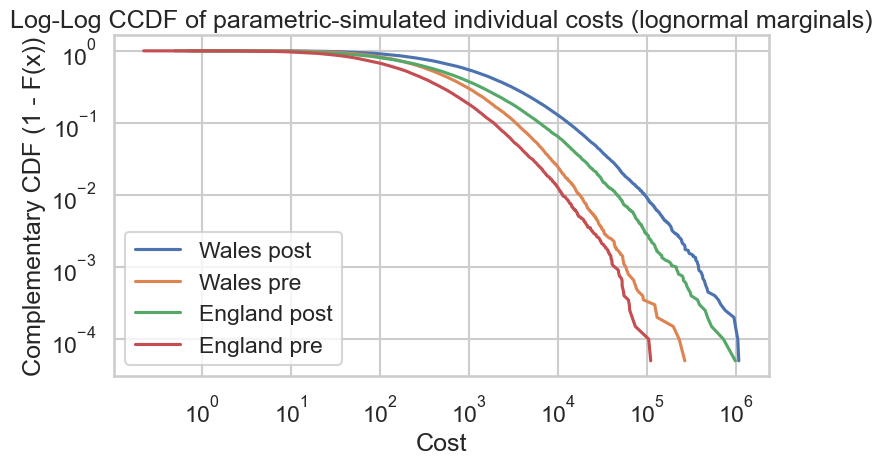

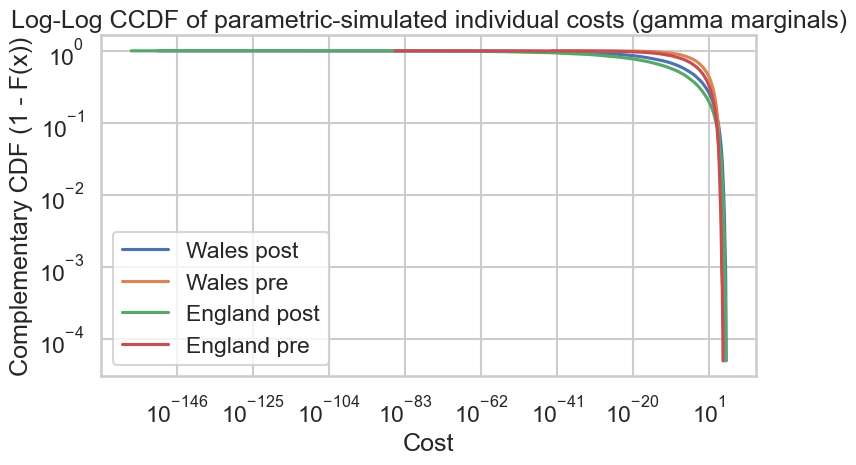

In [40]:
# ---------------- Log-log CCDFs of parametric-simulated individuals (lognormal marginals) ----------------
def simulate_individuals_from_summary(mean_obs, sd_obs, n_sim=20000, dist="lognormal", rng=None):
    """
    Simulate individual-level samples from a parametric distribution
    fitted to mean and standard deviation.

    Parameters:
    - mean_obs: observed mean
    - sd_obs: observed standard deviation
    - n_sim: number of simulated individuals (default 20,000)
    - dist: distribution type, either "lognormal" or "gamma" (default "lognormal")
    - rng: numpy random generator (optional)

    Returns:
    - np.ndarray of simulated values
    """
    rng = np.random.default_rng(seed) if rng is None else rng
    m = max(mean_obs, 1e-12)
    s = max(sd_obs, 1e-12)

    if dist == "lognormal":
        sigma2 = math.log1p((s**2) / (m**2))
        sigma = math.sqrt(max(sigma2, 0.0))
        mu_log = math.log(m) - 0.5 * sigma2
        return rng.lognormal(mean=mu_log, sigma=sigma, size=n_sim)

    elif dist == "gamma":
        alpha = max((m**2) / (s**2), 1e-6)
        theta = max((s**2) / m, 1e-6)
        return rng.gamma(shape=alpha, scale=theta, size=n_sim)

    else:
        raise ValueError("dist must be 'lognormal' or 'gamma'")

# Example usage:
n_sim = 20000
rng = np.random.default_rng(seed+1)

sim_W_post = simulate_individuals_from_summary(mean_post_w, sd_post_w, n_sim, dist="lognormal", rng=rng)
sim_W_pre  = simulate_individuals_from_summary(mean_pre_w, sd_pre_w, n_sim, dist="lognormal", rng=rng)
sim_E_post = simulate_individuals_from_summary(mean_post_e, sd_post_e, n_sim, dist="lognormal", rng=rng)
sim_E_pre  = simulate_individuals_from_summary(mean_pre_e, sd_pre_e, n_sim, dist="lognormal", rng=rng)


plt.figure(figsize=(8,5))
for arr, lab in [(sim_W_post, "Wales post"), (sim_W_pre, "Wales pre"), (sim_E_post, "England post"), (sim_E_pre, "England pre")]:
    s = np.sort(arr)
    ccdf = 1.0 - np.arange(1, len(s)+1) / (len(s)+1)
    plt.loglog(s, ccdf, label=lab)
plt.xlabel("Cost")
plt.ylabel("Complementary CDF (1 - F(x))")
plt.title("Log-Log CCDF of parametric-simulated individual costs (lognormal marginals)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "loglog_ccdf_simulated_individuals.png"), dpi=200)
plt.show()


sim_W_post = simulate_individuals_from_summary(mean_post_w, sd_post_w, n_sim, dist="gamma", rng=rng)
sim_W_pre  = simulate_individuals_from_summary(mean_pre_w, sd_pre_w, n_sim, dist="gamma", rng=rng)
sim_E_post = simulate_individuals_from_summary(mean_post_e, sd_post_e, n_sim, dist="gamma", rng=rng)
sim_E_pre  = simulate_individuals_from_summary(mean_pre_e, sd_pre_e, n_sim, dist="gamma", rng=rng)


plt.figure(figsize=(8,5))
for arr, lab in [(sim_W_post, "Wales post"), (sim_W_pre, "Wales pre"), (sim_E_post, "England post"), (sim_E_pre, "England pre")]:
    s = np.sort(arr)
    ccdf = 1.0 - np.arange(1, len(s)+1) / (len(s)+1)
    plt.loglog(s, ccdf, label=lab)
plt.xlabel("Cost")
plt.ylabel("Complementary CDF (1 - F(x))")
plt.title("Log-Log CCDF of parametric-simulated individual costs (gamma marginals)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "loglog_ccdf_simulated_individuals.png"), dpi=200)
plt.show()


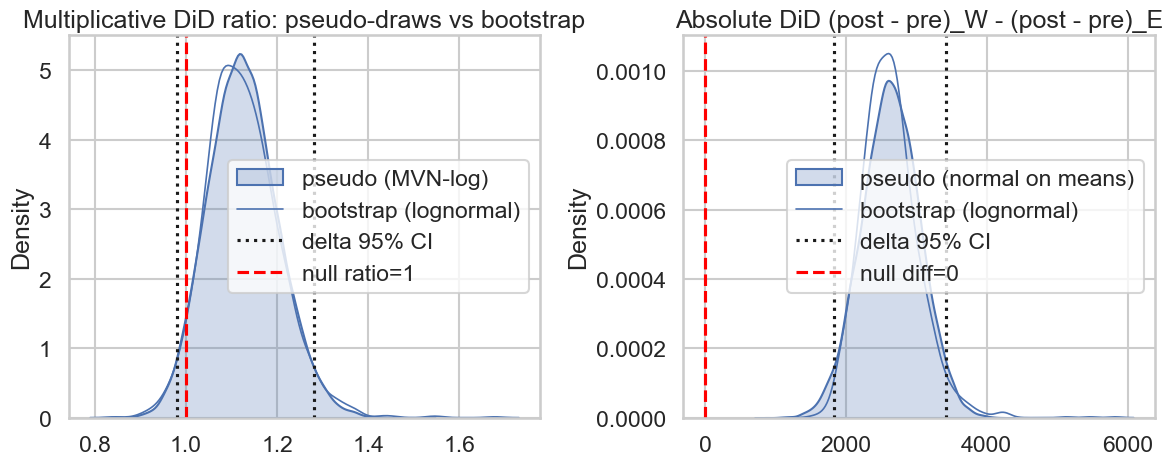

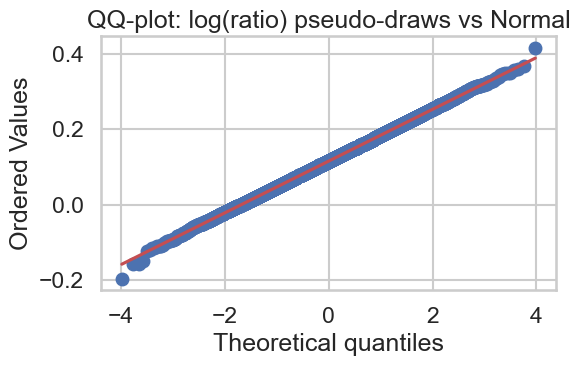

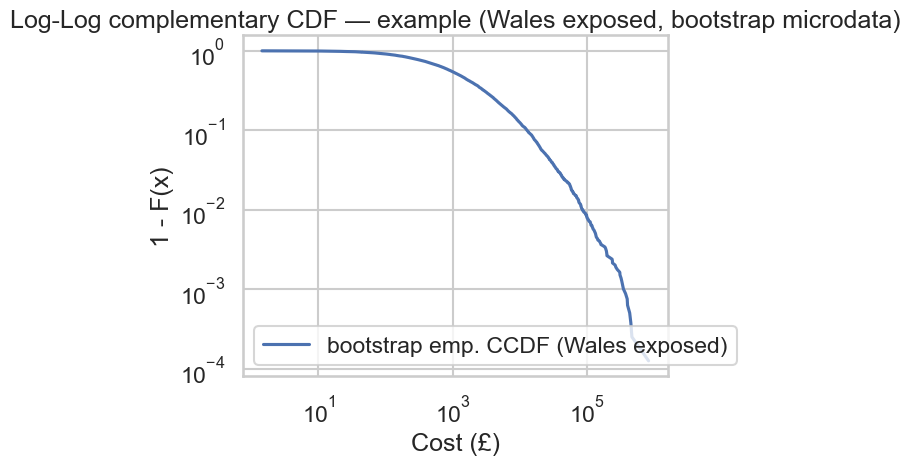


Summary table:


,method,estimand,estimate,se_log,ci_low,ci_high,se,sd
0,delta_analytic,ratio,1.1220,0.0682,0.9817,1.2823,NaN,NaN
1,delta_analytic,abs_DiD,2630.4000,NaN,1839.0136,3421.7864,403.776,NaN
2,pseudo_draws,ratio,1.1253,NaN,0.9812,1.2831,NaN,0.0766
3,bootstrap,ratio,1.1248,NaN,0.9823,1.2940,NaN,0.0805
4,pseudo_draws,abs_DiD,2645.7106,NaN,1886.3165,3486.0643,NaN,406.2628
5,bootstrap,abs_DiD,2630.0158,NaN,1949.4095,3503.1869,NaN,407.9581



P-values summary (analytic + empirical):
{'analytic_pval_abs': 7.293077253223146e-11,
 'analytic_pval_ratio': 0.0912424761739894,
 'emp_pval_abs_boot': 0.0009995002498750624,
 'emp_pval_abs_pseudo': 9.99950002499875e-05,
 'emp_pval_ratio_boot': 0.08295852073963018,
 'emp_pval_ratio_pseudo_log': 0.0919954002299885,
 'emp_pval_ratio_pseudo_raw': 0.0919954002299885,
 'pval_abs_report': 7.293077253223146e-11,
 'pval_ratio_report': 0.0912424761739894}


In [42]:
# ---------------- Plots & Diagnostics ----------------
# 1) KDE: ratio (pseudo vs bootstrap) and absolute DiD (pseudo vs bootstrap)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.kdeplot(pseudo["ratio_draws"], fill=True, label="pseudo (MVN-log)")
sns.kdeplot(boot["ratio_boot"], fill=False, lw=1.2, label=f"bootstrap ({bootstrap_marginal})")
plt.axvline(delta_ratio["ci_low"], color='k', ls=':', label='delta 95% CI')
plt.axvline(delta_ratio["ci_high"], color='k', ls=':')
plt.axvline(1.0, color='red', ls='--', label='null ratio=1')
plt.title("Multiplicative DiD ratio: pseudo-draws vs bootstrap")
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(pseudo["abs_draws"], fill=True, label="pseudo (normal on means)")
sns.kdeplot(boot["abs_boot"], fill=False, lw=1.2, label=f"bootstrap ({bootstrap_marginal})")
plt.axvline(delta_abs["ci_low"], color='k', ls=':', label='delta 95% CI')
plt.axvline(delta_abs["ci_high"], color='k', ls=':')
plt.axvline(0.0, color='red', ls='--', label='null diff=0')
plt.title("Absolute DiD (post - pre)_W - (post - pre)_E")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "kde_ratio_abs_comparison.png"), dpi=200)
plt.show()

# 2) QQ-plot for log(ratio) pseudo-draws
plt.figure(figsize=(6,4))
logratio = np.log(pseudo["ratio_draws"][~np.isnan(pseudo["ratio_draws"]) & (pseudo["ratio_draws"]>0)])
if logratio.size > 10:
    stats.probplot(logratio, dist="norm", plot=plt)
    plt.title("QQ-plot: log(ratio) pseudo-draws vs Normal")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "qq_logratio_pseudo.png"), dpi=200)
    plt.show()

# 3) CCDF (log-log) from last bootstrap microdata (good for tail behavior)
try:
    last = boot["last_micro"]
    # show CCDF for exposed Wales microdata as example
    vals = np.sort(last["exp_w"])
    ccdf = 1.0 - np.arange(1, len(vals)+1) / (len(vals)+1)
    plt.figure(figsize=(6,5))
    plt.loglog(vals, ccdf, label='bootstrap emp. CCDF (Wales exposed)')
    plt.xlabel("Cost (£)"); plt.ylabel("1 - F(x)")
    plt.title("Log-Log complementary CDF — example (Wales exposed, bootstrap microdata)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "ccdf_wales_exposed_boot.png"), dpi=200)
    plt.show()
except Exception:
    pass

# save summary and raw draws
summary_df.to_csv(os.path.join(output_dir, "paired_delta_summary.csv"), index=False)
np.savez_compressed(os.path.join(output_dir, "paired_delta_draws.npz"),
                    ratio_pseudo=pseudo["ratio_draws"], abs_pseudo=pseudo["abs_draws"],
                    ratio_boot=boot["ratio_boot"], abs_boot=boot["abs_boot"],
                    fold_w=pseudo["fold_w"], fold_e=pseudo["fold_e"])

# Print summary
pd.set_option("display.precision", 4)
print("\nSummary table:")
display(summary_df)

print("\nP-values summary (analytic + empirical):")
import pprint
pprint.pprint(pvals)


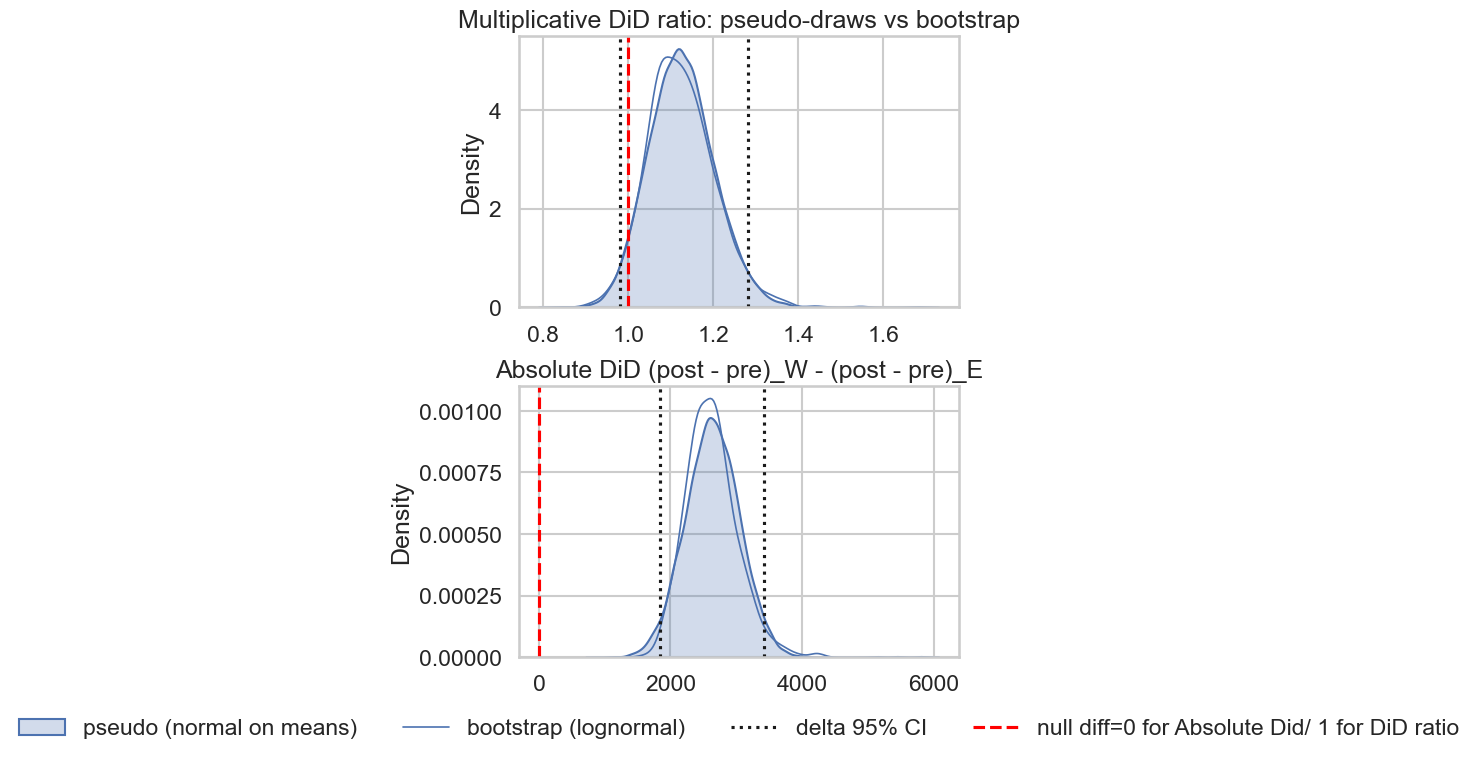

In [62]:
plt.figure(figsize=(11,9))
plt.subplot(2,1,1)
sns.kdeplot(pseudo["ratio_draws"], fill=True, label="pseudo (MVN-log)")
sns.kdeplot(boot["ratio_boot"], fill=False, lw=1.2, label=f"bootstrap ({bootstrap_marginal})")
plt.axvline(delta_ratio["ci_low"], color='k', ls=':', label='delta 95% CI')
plt.axvline(delta_ratio["ci_high"], color='k', ls=':')
plt.axvline(1.0, color='red', ls='--', label='null ratio=1')
plt.title("Multiplicative DiD ratio: pseudo-draws vs bootstrap")
#plt.legend(loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.subplot(2,1,2)
sns.kdeplot(pseudo["abs_draws"], fill=True, label="pseudo (normal on means)")
sns.kdeplot(boot["abs_boot"], fill=False, lw=1.2, label=f"bootstrap ({bootstrap_marginal})")
plt.axvline(delta_abs["ci_low"], color='k', ls=':', label='delta 95% CI')
plt.axvline(delta_abs["ci_high"], color='k', ls=':')
plt.axvline(0.0, color='red', ls='--', label='null diff=0 for Absolute Did/ 1 for DiD ratio')
plt.title("Absolute DiD (post - pre)_W - (post - pre)_E")
plt.legend(loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.15))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make space for legend below plots
plt.savefig(os.path.join(output_dir, "kde_ratio_abs_comparison.png"), dpi=200)
plt.show()
